In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statistics import mean
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from datetime import datetime, timedelta
%matplotlib inline

In [4]:
pip install pyrsm

   ---------------------------------------- 0.0/631.6 kB ? eta -:--:--
   --------------------------------- ------ 524.3/631.6 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 631.6/631.6 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/607.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/607.2 kB ? eta -:--:--
   --------------------------------------- 607.2/607.2 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/32.9 MB ? eta -:--:--
   - -------------------------------------- 1.0/32.9 MB 8.5 MB/s eta 0:00:04
   -- ------------------------------------- 2.4/32.9 MB 6.1 MB/s eta 0:00:06
   ----- ---------------------------------- 4.2/32.9 MB 6.8 MB/s eta 0:00:05
   ------- -------------------------------- 6.0/32.9 MB 7.5 MB/s eta 0:00:04
   --------- ------------------------------ 8.1/32.9 MB 8.0 MB/s eta 0:00:04
   ----------- ---------------------------- 9.7/32.9 MB 8.1 MB/s eta 0:00:03
   ------------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 0.5.23 requires tokenizers<=0.20.3,>=0.13.2, but you have tokenizers 0.21.0 which is incompatible.
gradio 5.1.0 requires tomlkit==0.12.0, but you have tomlkit 0.13.2 which is incompatible.
gradio-client 1.4.0 requires websockets<13.0,>=10.0, but you have websockets 14.2 which is incompatible.
langserve 0.3.0 requires langchain-core<0.4,>=0.3, but you have langchain-core 0.2.22 which is incompatible.
mlflow 2.16.2 requires pyarrow<18,>=4.0.0, but you have pyarrow 19.0.0 which is incompatible.
prefect 3.0.1 requires websockets<14.0,>=10.4, but you have websockets 14.2 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.


### Read Data

In [8]:
products = pd.read_excel("data/Breakfast at the Frat.xlsx", sheet_name='dh Products Lookup', header=1)
products = products.iloc[0:58, 0:6]
products.UPC = products.UPC.astype(int)
products.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111035398,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UPC           58 non-null     int32 
 1   DESCRIPTION   58 non-null     object
 2   MANUFACTURER  58 non-null     object
 3   CATEGORY      58 non-null     object
 4   SUB_CATEGORY  58 non-null     object
 5   PRODUCT_SIZE  58 non-null     object
dtypes: int32(1), object(5)
memory usage: 2.6+ KB


In [14]:
store = pd.read_excel("data/Breakfast at the Frat.xlsx", sheet_name='dh Store Lookup', header=1)
store = store.iloc[:,0:9]
store.drop_duplicates(subset ="STORE_ID", keep = "first", inplace = True)
store.head()

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24766.807692
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.519231
2,4259,WARSAW AVENUE,CINCINNATI,OH,17140,VALUE,NaN,48813,31177.333333
3,6379,KINGWOOD,KINGWOOD,TX,26420,MAINSTREAM,NaN,50237,20620.423077
4,6431,AT WARD ROAD,BAYTOWN,TX,26420,VALUE,350.0,43698,24321.942308


In [16]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   STORE_ID                 77 non-null     int64  
 1   STORE_NAME               77 non-null     object 
 2   ADDRESS_CITY_NAME        77 non-null     object 
 3   ADDRESS_STATE_PROV_CODE  77 non-null     object 
 4   MSA_CODE                 77 non-null     int64  
 5   SEG_VALUE_NAME           77 non-null     object 
 6   PARKING_SPACE_QTY        26 non-null     float64
 7   SALES_AREA_SIZE_NUM      77 non-null     int64  
 8   AVG_WEEKLY_BASKETS       77 non-null     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 6.0+ KB


In [20]:
trans_cereal = pd.read_csv("data/transaction_cereal.csv", index_col = 0)
trans_cereal

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,0.0,0.0
7,2009-01-14,367.0,1111085345,29.0,26.0,25.0,54.52,1.88,1.88,0.0,0.0,0.0
8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,0.0,0.0
12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,0.0,0.0
13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
524931,2012-01-04,29159.0,3800031838,48.0,43.0,39.0,157.92,3.29,3.29,0.0,0.0,0.0
524932,2012-01-04,29159.0,3800039118,21.0,17.0,17.0,70.98,3.38,3.38,0.0,0.0,0.0
524947,2012-01-04,29159.0,88491201426,32.0,29.0,23.0,105.92,3.31,3.31,0.0,0.0,0.0
524948,2012-01-04,29159.0,88491201427,30.0,26.0,23.0,99.30,3.31,3.31,0.0,0.0,0.0


### Merge Data (keep only cereal)

In [23]:
cereal = trans_cereal.merge(products, on='UPC')
cereal = cereal.merge(store, left_on='STORE_NUM', right_on='STORE_ID')
cereal

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,PRODUCT_SIZE,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
1,2009-01-14,367.0,1111085345,29.0,26.0,25.0,54.52,1.88,1.88,0.0,...,20 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
2,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,...,18 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
3,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
4,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,...,18 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71845,2012-01-04,29159.0,1111085345,10.0,5.0,5.0,16.30,1.63,1.63,0.0,...,20 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051
71846,2012-01-04,29159.0,1111085350,16.0,13.0,13.0,36.32,2.27,2.27,0.0,...,18 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051
71847,2012-01-04,29159.0,1600027527,149.0,114.0,114.0,298.00,2.00,3.00,0.0,...,12.25 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051
71848,2012-01-04,29159.0,1600027528,20.0,19.0,19.0,91.80,4.59,4.59,0.0,...,18 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051


In [25]:
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME"]
cereal[cat] = cereal[cat].astype("category")

In [27]:
# Create a dataframe for only cereal from Kellogg
# cereal_Kellogg = cereal[cereal.MANUFACTURER == "KELLOGG"]

---

### EDA_Product

In [98]:
# There are only three products from Kellogg cereal
cereal_Kellogg = pd.read_csv("data/cereal_Kellogg_Month.csv", index_col = 0)
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME"]
cereal_Kellogg[cat] = cereal_Kellogg[cat].astype("category")
cereal_Kellogg['WEEK_END_DATE'] = pd.to_datetime(cereal_Kellogg['WEEK_END_DATE'])
cereal_Kellogg['MONTH'] = cereal_Kellogg['WEEK_END_DATE'].dt.month
cereal_Kellogg['YEAR'] = cereal_Kellogg['WEEK_END_DATE'].dt.year
cereal_Kellogg['MONTH'] = cereal_Kellogg['MONTH'].astype("category")
cereal_Kellogg['YEAR'] = cereal_Kellogg['YEAR'].astype("category")
cereal_Kellogg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35832 entries, 1331 to 169279
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WEEK_END_DATE            35832 non-null  datetime64[ns]
 1   STORE_NUM                35832 non-null  category      
 2   UPC                      35832 non-null  category      
 3   UNITS                    35832 non-null  int64         
 4   VISITS                   35832 non-null  int64         
 5   HHS                      35832 non-null  int64         
 6   SPEND                    35832 non-null  float64       
 7   PRICE                    35832 non-null  float64       
 8   BASE_PRICE               35830 non-null  float64       
 9   FEATURE                  35832 non-null  category      
 10  DISPLAY                  35832 non-null  category      
 11  TPR_ONLY                 35832 non-null  category      
 12  DESCRIPTION              35832 no

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\28422655.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cereal_Kellogg['WEEK_END_DATE'] = pd.to_datetime(cereal_Kellogg['WEEK_END_DATE'])


In [100]:
# there are only 3 products
cereal_Kellogg.UPC.unique()

[3800031829, 3800031838, 3800039118]
Categories (3, int64): [3800031829, 3800031838, 3800039118]

In [102]:
cereal_Kellogg.DESCRIPTION.unique()

array(['KELL BITE SIZE MINI WHEAT', 'KELL FROSTED FLAKES',
       'KELL FROOT LOOPS'], dtype=object)

In [104]:
cereal_Kellogg.groupby('UPC')[['UNITS', 'BASE_PRICE', 'PRICE']].mean()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\852786689.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg.groupby('UPC')[['UNITS', 'BASE_PRICE', 'PRICE']].mean()


,UNITS,BASE_PRICE,PRICE
UPC,,,
3800031829,33.303007,3.273618,3.164362
3800031838,47.236561,3.044505,2.886601
3800039118,38.386257,3.144723,2.930515


### EDA_Store

In [107]:
# Counts by STORE_ID
cereal_Kellogg.STORE_ID.value_counts()

STORE_ID
29159    468
21485    468
11967    468
11993    468
12011    468
        ... 
23061    465
23055    463
23327    463
8035     390
387      382
Name: count, Length: 77, dtype: int64

In [109]:
# Counts by STORE_NAME
cereal_Kellogg.STORE_NAME.value_counts()

STORE_NAME
HOUSTON                 1867
MIDDLETOWN               936
PINEWOOD                 468
KINGWOOD                 468
KROGER JUNCTION S/C      468
                        ... 
NORWOOD                  465
LIBERTY TWP.             465
WALNUT HILLS/PEEBLES     463
OVER-THE-RHINE           390
TOWN & COUNTRY           382
Name: count, Length: 73, dtype: int64

In [111]:
# Counts by STATE
cereal_Kellogg.ADDRESS_STATE_PROV_CODE.value_counts()

ADDRESS_STATE_PROV_CODE
TX    19169
OH    14326
KY     1869
IN      468
Name: count, dtype: int64

<Axes: ylabel='ADDRESS_STATE_PROV_CODE'>

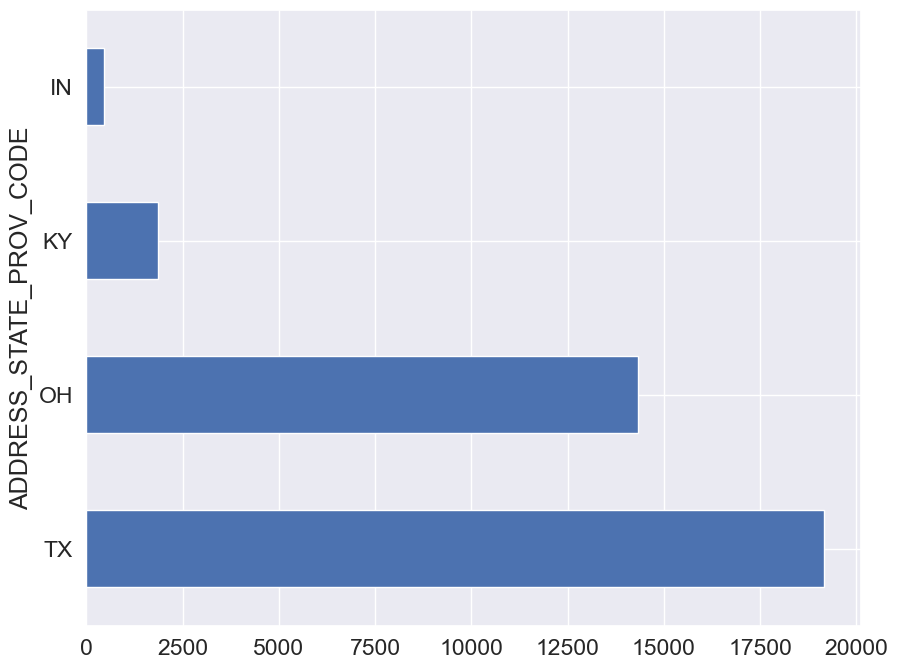

In [113]:
# Counts by STATE
plt.rcParams["figure.figsize"] = [10,8]
cereal_Kellogg.ADDRESS_STATE_PROV_CODE.value_counts().plot(kind='barh')

<Axes: ylabel='ADDRESS_CITY_NAME'>

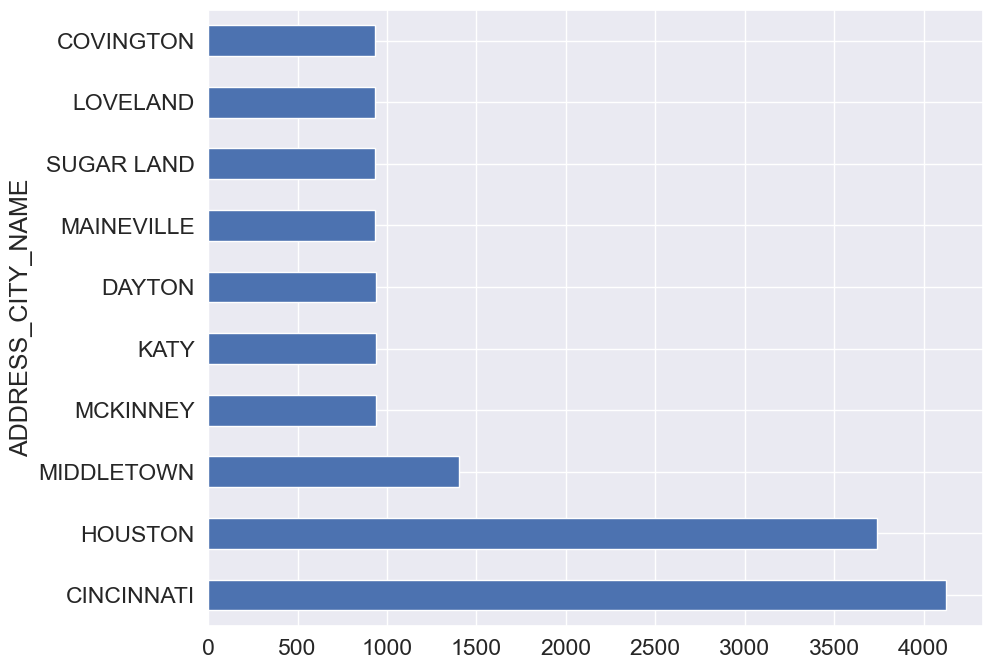

In [115]:
# Counts by CITY
cereal_Kellogg.ADDRESS_CITY_NAME.value_counts().head(10).plot(kind='barh')

In [117]:
# Kellogg Cereal UNITS by state & store
cereal_Kellogg_geo = cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE", "STORE_NAME"])["UNITS"].sum().to_frame(name="UNITS").reset_index()
cereal_Kellogg_geo[cereal_Kellogg_geo.UNITS != 0].sort_values("UNITS", ascending = False)

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\1194209977.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg_geo = cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE", "STORE_NAME"])["UNITS"].sum().to_frame(name="UNITS").reset_index()


,ADDRESS_STATE_PROV_CODE,STORE_NAME,UNITS
245,TX,HOUSTON,72311
191,OH,MIDDLETOWN,46830
154,OH,CINCINNATI,45907
147,OH,ANDERSON TOWNE CTR,36760
159,OH,DAYTON,34566
...,...,...,...
273,TX,RICHARDSON,9456
213,OH,WALNUT HILLS/PEEBLES,8530
270,TX,PARKWAY SQUARE S/C,8208
196,OH,OVER-THE-RHINE,6877


In [119]:
# Kellogg Cereal UNITS by state
cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE"])["UNITS"].sum().to_frame(name='UNITS').reset_index()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\2738081543.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE"])["UNITS"].sum().to_frame(name='UNITS').reset_index()


,ADDRESS_STATE_PROV_CODE,UNITS
0,IN,20328
1,KY,88984
2,OH,668500
3,TX,643160


<Axes: ylabel='MSA_CODE'>

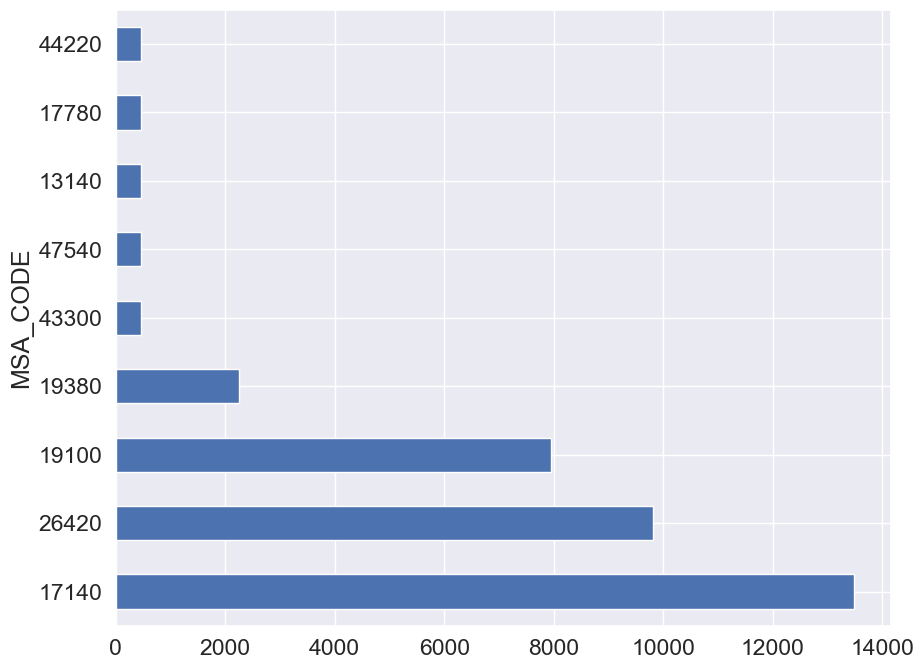

In [121]:
cereal_Kellogg.MSA_CODE.value_counts().plot(kind='barh')

<Axes: ylabel='SEG_VALUE_NAME'>

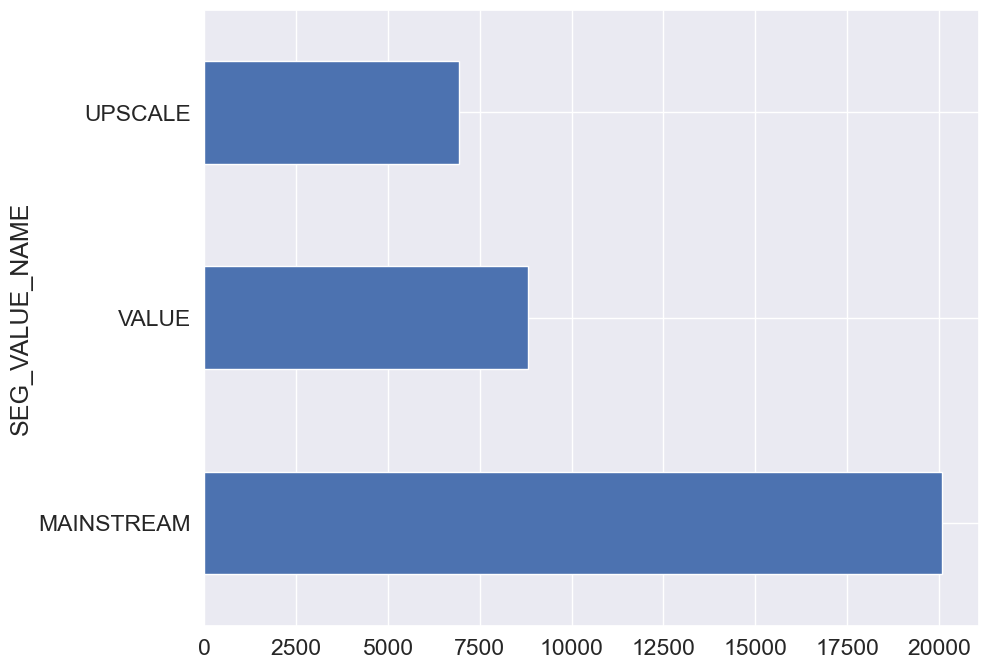

In [123]:
cereal_Kellogg.SEG_VALUE_NAME.value_counts().plot(kind='barh')

In [125]:
cereal_Kellogg[['PARKING_SPACE_QTY']].describe()

,PARKING_SPACE_QTY
count,11986.000000
mean,483.936676
std,404.376283
min,17.000000
25%,270.000000
50%,351.000000
75%,464.000000
max,1859.000000


In [127]:
cereal_Kellogg[['SALES_AREA_SIZE_NUM']].describe()

,SALES_AREA_SIZE_NUM
count,35832.000000
mean,49024.816142
std,13436.934048
min,10788.000000
25%,42437.000000
50%,48462.000000
75%,54448.000000
max,86517.000000


<Axes: >

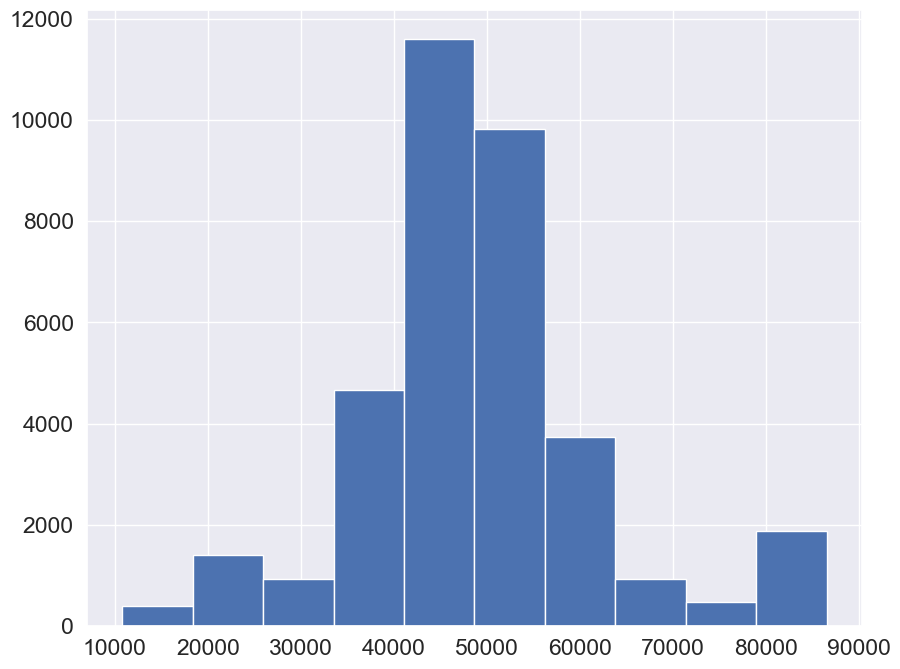

In [129]:
cereal_Kellogg.SALES_AREA_SIZE_NUM.hist()

In [131]:
cereal_Kellogg[['AVG_WEEKLY_BASKETS']].describe()

,AVG_WEEKLY_BASKETS
count,35832.000000
mean,24247.302480
std,8745.542387
min,10434.705130
25%,17009.897440
50%,24567.750000
75%,29386.416670
max,54052.519230


<Axes: >

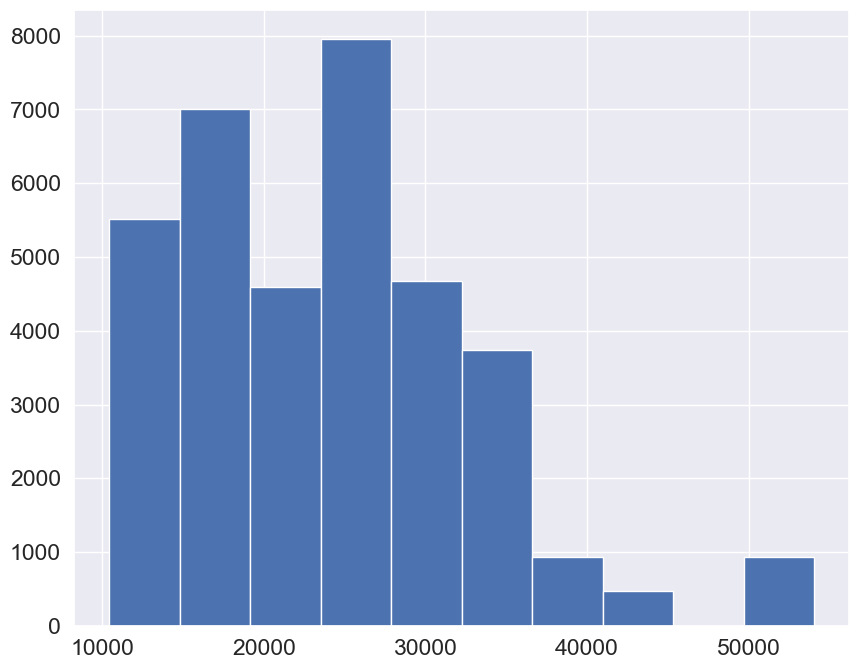

In [133]:
cereal_Kellogg.AVG_WEEKLY_BASKETS.hist()

<Axes: xlabel='SEG_VALUE_NAME', ylabel='SALES_AREA_SIZE_NUM'>

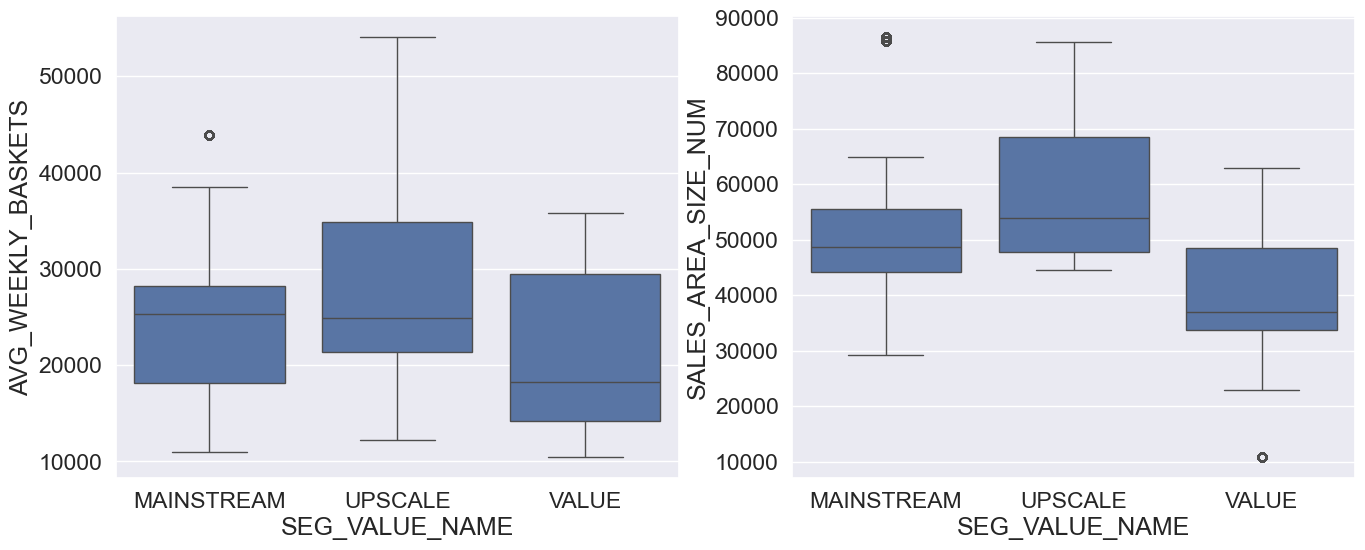

In [135]:
fig, axes=plt.subplots(1,2,figsize=(16,6))
sns.boxplot(x="SEG_VALUE_NAME", y="AVG_WEEKLY_BASKETS", data=cereal_Kellogg, ax=axes[0])
sns.boxplot(x="SEG_VALUE_NAME", y="SALES_AREA_SIZE_NUM", data=cereal_Kellogg, ax=axes[1])

### Transaction

<Axes: >

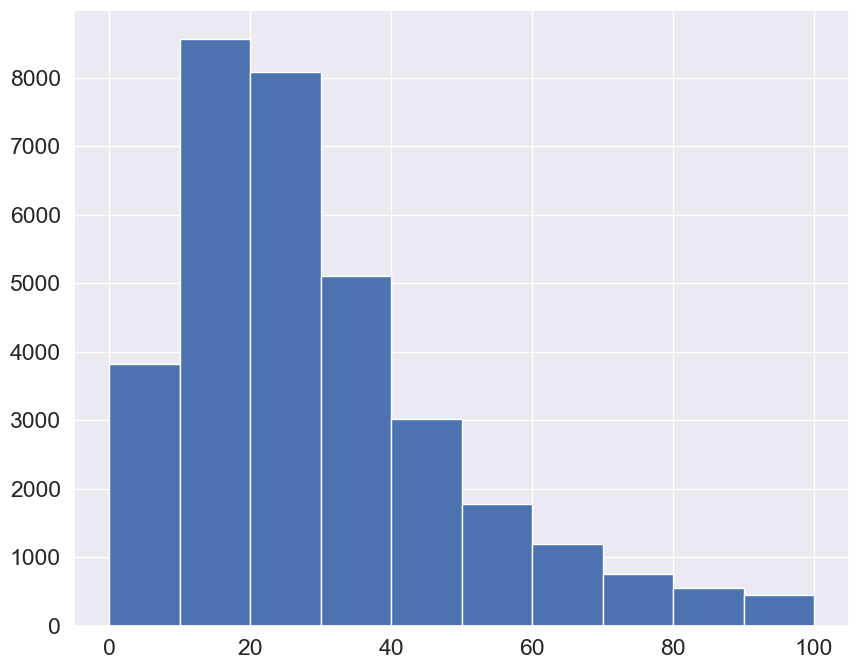

In [138]:
plt.rcParams["figure.figsize"] = [10,8]
cereal_Kellogg.UNITS.hist(range=(0,100))

<Axes: >

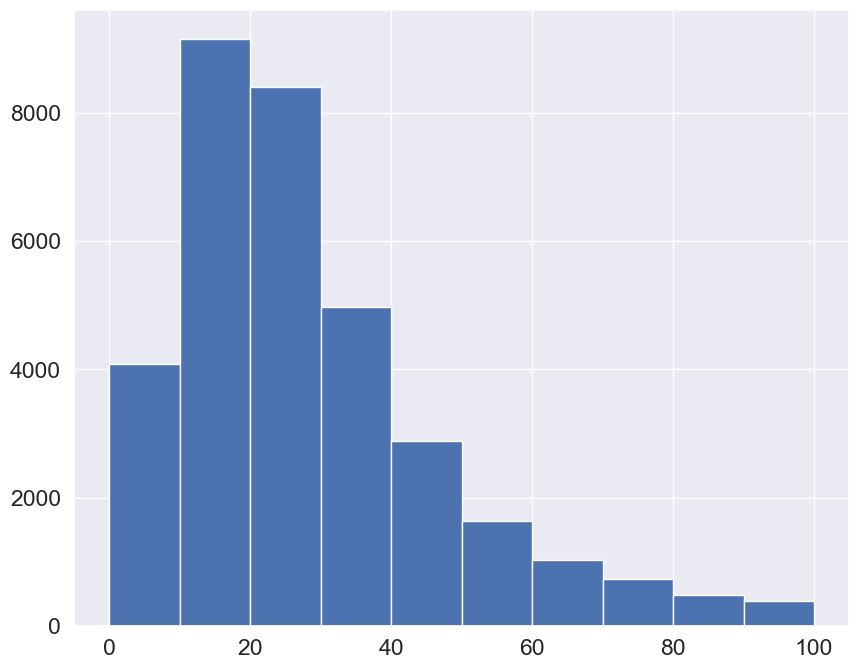

In [140]:
cereal_Kellogg.VISITS.hist(range=(0,100))

In [142]:
# units, visits and hhs have very high correlation
cereal_Kellogg[['UNITS','VISITS','HHS']].corr()

,UNITS,VISITS,HHS
UNITS,1.000000,0.992420,0.989704
VISITS,0.992420,1.000000,0.998354
HHS,0.989704,0.998354,1.000000


Examine 'UNITS/VISITS' metric. Identified extremely high ratio above 10.

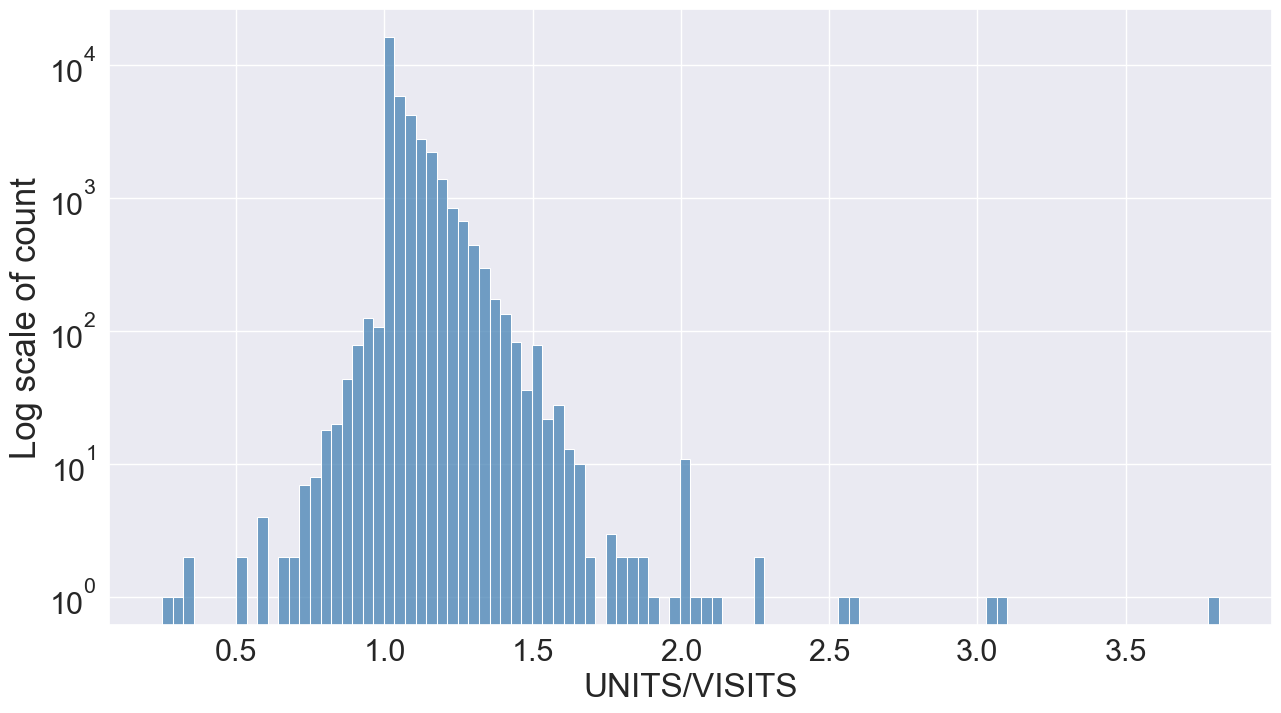

In [145]:
plt.rcParams["figure.figsize"] = [15,8]
cereal_Kellogg["UNITS/VISITS"] = cereal_Kellogg.UNITS / cereal_Kellogg.VISITS
sns.set(font_scale=2)
plt.ylabel("Log scale of count", size = 25)
plot = sns.histplot(x='UNITS/VISITS', data = cereal_Kellogg, bins = 100, color = "steelblue")
plot.set_yscale('log')

-----

Examine 'VISITS/HHS' metric. Identified extremely high ratio around 20.

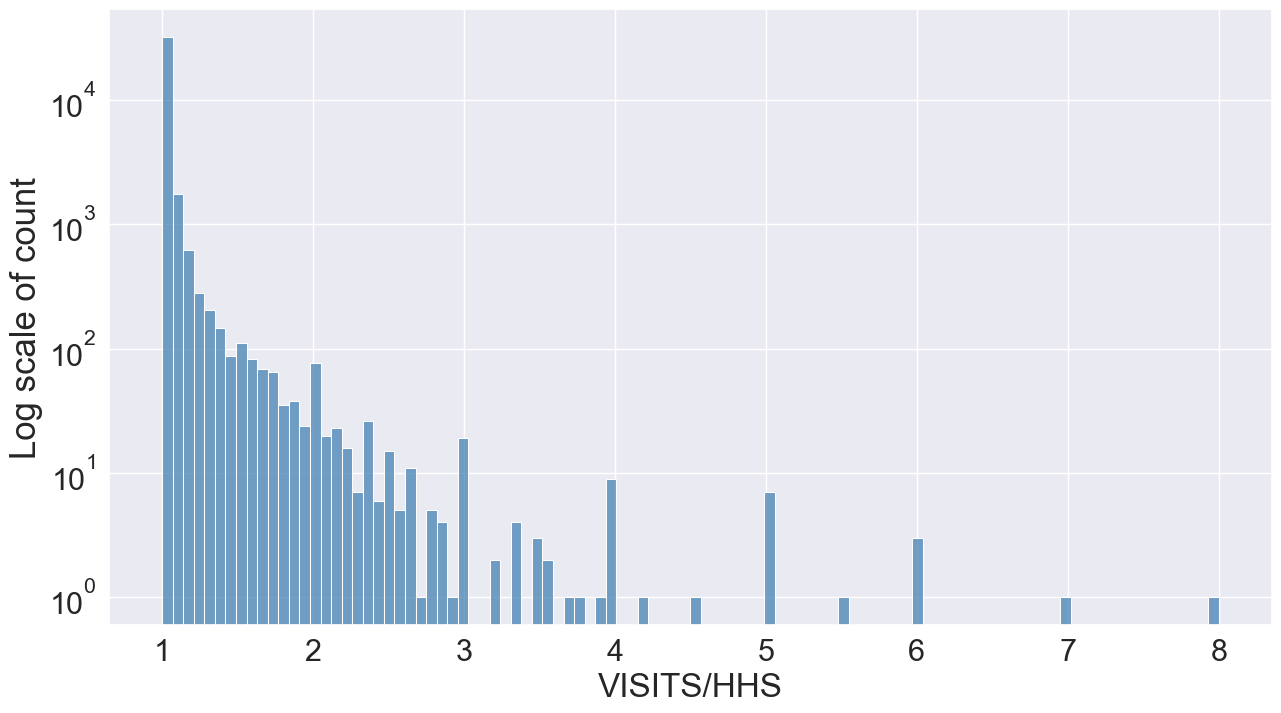

In [149]:
plt.rcParams["figure.figsize"] = [15,8]
cereal_Kellogg["VISITS/HHS"] = cereal_Kellogg.VISITS / cereal_Kellogg.HHS
sns.set(font_scale=2)
plt.ylabel("Log scale of count", size = 25)
plot = sns.histplot(x='VISITS/HHS', data = cereal_Kellogg, bins = 100, color = "steelblue")
plot.set_yscale('log')

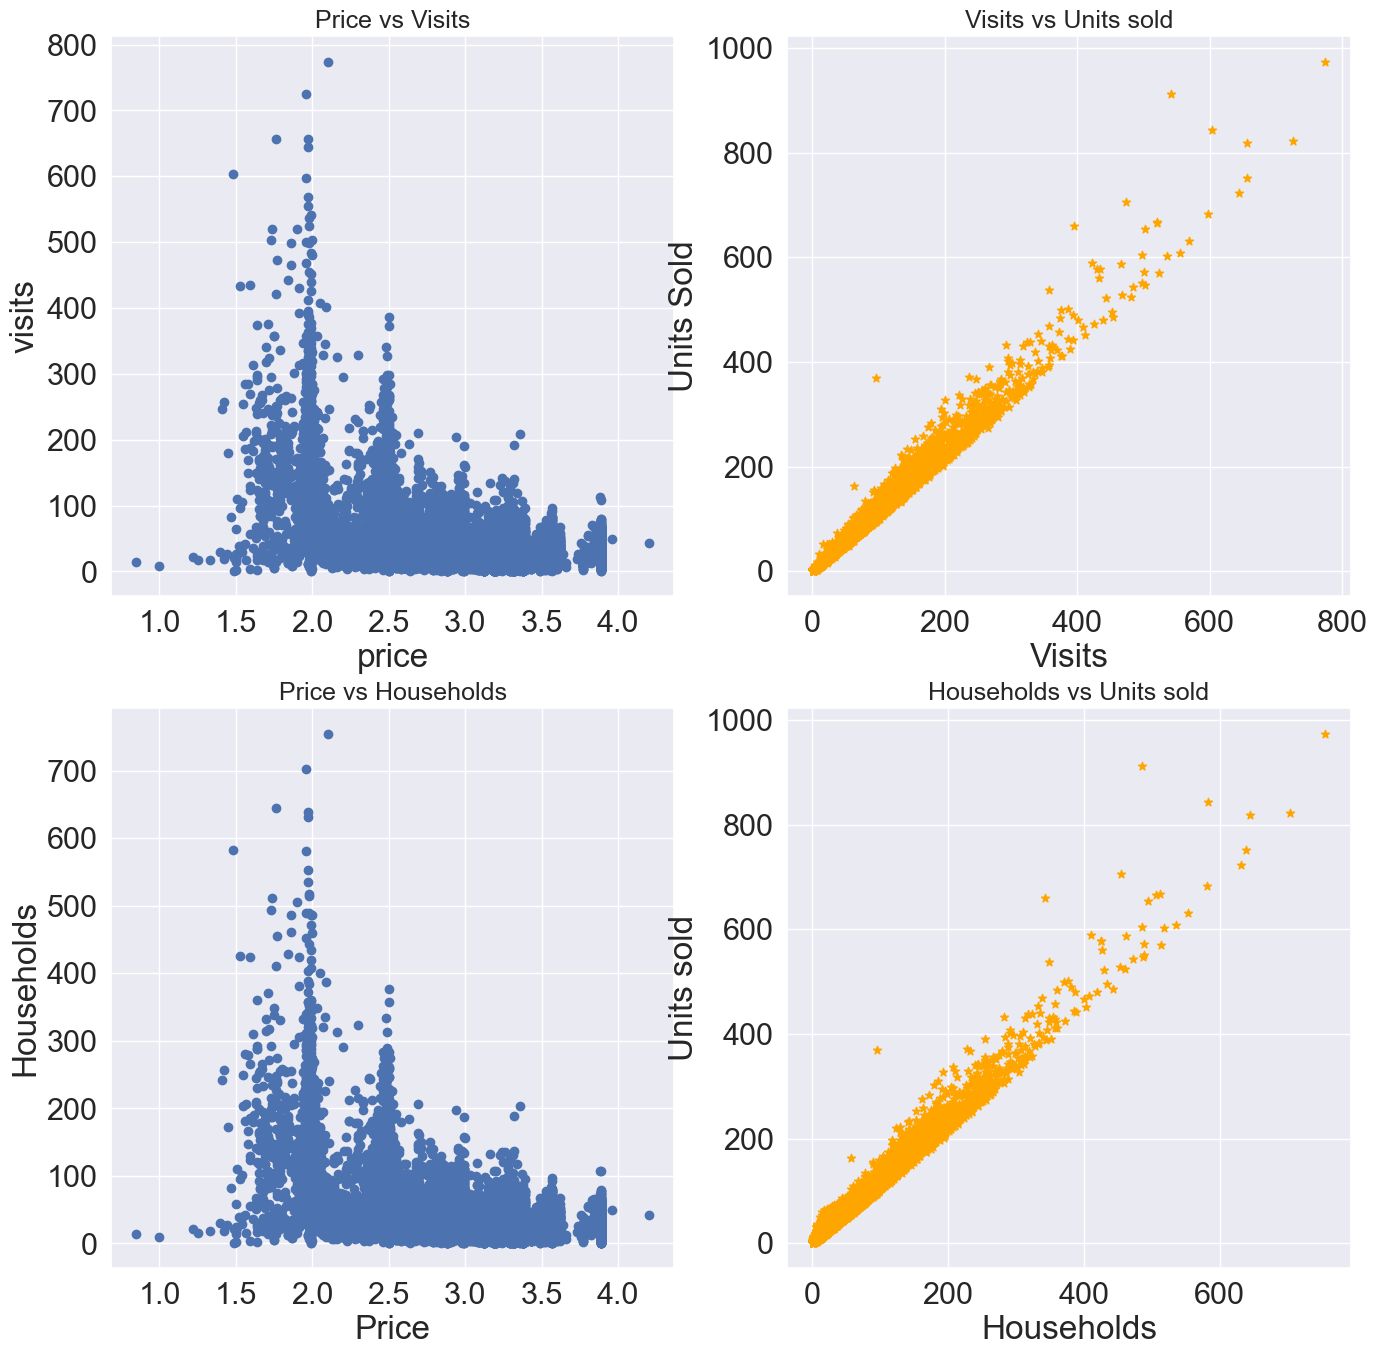

In [151]:
f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
ax[0,0].scatter(cereal_Kellogg.PRICE, cereal_Kellogg.VISITS, marker='o')
ax[0,0].set_xlabel('price')
ax[0,0].set_ylabel('visits')
ax[0,0].set_title('Price vs Visits')

ax[0,1].scatter(cereal_Kellogg.VISITS, cereal_Kellogg.UNITS, marker='*', color = 'orange')
ax[0,1].set_xlabel('Visits')
ax[0,1].set_ylabel('Units Sold')
ax[0,1].set_title('Visits vs Units sold')

ax[1,0].scatter(cereal_Kellogg.PRICE, cereal_Kellogg.HHS, marker='o')
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Households')
ax[1,0].set_title('Price vs Households')

ax[1,1].scatter(cereal_Kellogg.HHS, cereal_Kellogg.UNITS, marker='*', color = 'orange')
ax[1,1].set_xlabel('Households')
ax[1,1].set_ylabel('Units sold')
ax[1,1].set_title('Households vs Units sold')

plt.show()

Text(0.5, 1.0, 'Visits vs Households')

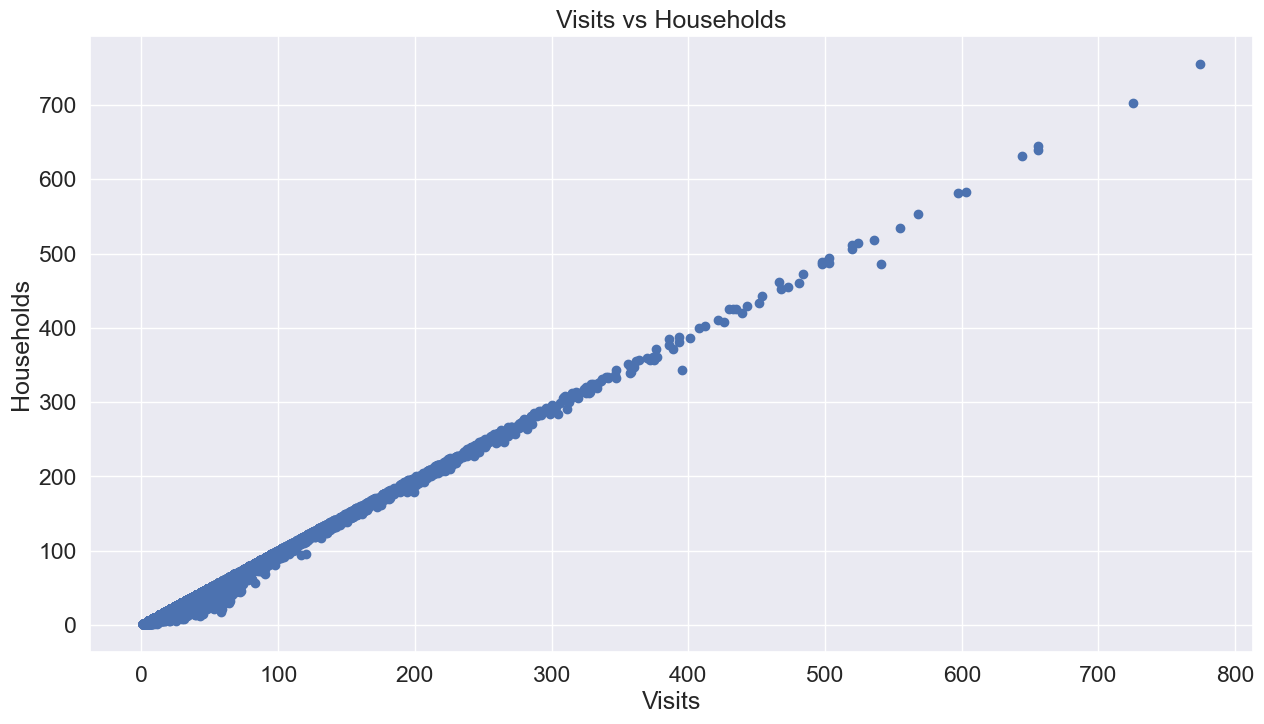

In [153]:
#f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
plot = plt.scatter(cereal_Kellogg.VISITS, cereal_Kellogg.HHS, marker='o')
plt.xlabel('Visits')
plt.ylabel('Households')
plt.title('Visits vs Households')

In [155]:
cereal_Kellogg[['PRICE','UNITS', 'VISITS', 'HHS']].corr()

,PRICE,UNITS,VISITS,HHS
PRICE,1.000000,-0.555772,-0.555260,-0.563047
UNITS,-0.555772,1.000000,0.992420,0.989704
VISITS,-0.555260,0.992420,1.000000,0.998354
HHS,-0.563047,0.989704,0.998354,1.000000


In [161]:
cereal_Kellogg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35832 entries, 1331 to 169279
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WEEK_END_DATE            35832 non-null  datetime64[ns]
 1   STORE_NUM                35832 non-null  category      
 2   UPC                      35832 non-null  category      
 3   UNITS                    35832 non-null  int64         
 4   VISITS                   35832 non-null  int64         
 5   HHS                      35832 non-null  int64         
 6   SPEND                    35832 non-null  float64       
 7   PRICE                    35832 non-null  float64       
 8   BASE_PRICE               35830 non-null  float64       
 9   FEATURE                  35832 non-null  category      
 10  DISPLAY                  35832 non-null  category      
 11  TPR_ONLY                 35832 non-null  category      
 12  DESCRIPTION              35832 no

In [157]:
sorted_date = cereal_Kellogg.WEEK_END_DATE.value_counts(sort=False).reset_index().sort_values('index').set_index('index')
sorted_date

KeyError: 'index'

In [165]:
print(cereal_Kellogg.columns)

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS', 'VISITS', 'HHS', 'SPEND',
       'PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'DESCRIPTION',
       'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY', 'PRODUCT_SIZE', 'STORE_ID',
       'STORE_NAME', 'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE',
       'MSA_CODE', 'SEG_VALUE_NAME', 'PARKING_SPACE_QTY',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'MONTH', 'YEAR',
       'UNITS/VISITS', 'VISITS/HHS'],
      dtype='object')


In [187]:
sorted_date = (cereal_Kellogg['WEEK_END_DATE']
               .value_counts(sort=False)
               .reset_index()
               .rename(columns={'index': 'WEEK_END_DATE', 'WEEK_END_DATE': 'count'})
               .sort_values('WEEK_END_DATE')
               .set_index('WEEK_END_DATE'))
sorted_date



KeyError: 'WEEK_END_DATE'

In [169]:
print(cereal_Kellogg.head())


      WEEK_END_DATE STORE_NUM         UPC  UNITS  VISITS  HHS  SPEND  PRICE  \
Index                                                                         
1331     2009-01-14       367  3800031829     14      11    3  43.96   3.14   
1332     2009-01-21       367  3800031829     17      13    6  53.38   3.14   
1333     2009-01-28       367  3800031829     23      19    8  72.22   3.14   
1334     2009-02-04       367  3800031829     25      23   10  78.50   3.14   
1335     2009-02-11       367  3800031829     23      19   11  72.22   3.14   

       BASE_PRICE FEATURE  ... ADDRESS_STATE_PROV_CODE MSA_CODE  \
Index                      ...                                    
1331         3.14       0  ...                      KY    17140   
1332         3.14       0  ...                      KY    17140   
1333         3.14       0  ...                      KY    17140   
1334         3.14       0  ...                      KY    17140   
1335         3.14       0  ...              

In [171]:
value_counts_result = cereal_Kellogg['WEEK_END_DATE'].value_counts(sort=False)
print(value_counts_result.head())


WEEK_END_DATE
2009-01-14    230
2009-01-21    229
2009-01-28    230
2009-02-04    230
2009-02-11    227
Name: count, dtype: int64


In [173]:
reset_index_result = value_counts_result.reset_index()
print(reset_index_result.head())


  WEEK_END_DATE  count
0    2009-01-14    230
1    2009-01-21    229
2    2009-01-28    230
3    2009-02-04    230
4    2009-02-11    227


In [175]:
print(reset_index_result.columns)


Index(['WEEK_END_DATE', 'count'], dtype='object')


In [177]:
sorted_result = reset_index_result.sort_values('index')
print(sorted_result.head())


KeyError: 'index'

In [179]:
print(reset_index_result.columns)


Index(['WEEK_END_DATE', 'count'], dtype='object')


In [181]:
print(reset_index_result.head())


  WEEK_END_DATE  count
0    2009-01-14    230
1    2009-01-21    229
2    2009-01-28    230
3    2009-02-04    230
4    2009-02-11    227


In [183]:
sorted_result = reset_index_result.sort_values('WEEK_END_DATE')
print(sorted_result.head())


  WEEK_END_DATE  count
0    2009-01-14    230
1    2009-01-21    229
2    2009-01-28    230
3    2009-02-04    230
4    2009-02-11    227


In [185]:
sorted_date = reset_index_result.sort_values('WEEK_END_DATE').set_index('WEEK_END_DATE')
print(sorted_date.head())


               count
WEEK_END_DATE       
2009-01-14       230
2009-01-21       229
2009-01-28       230
2009-02-04       230
2009-02-11       227


<Axes: xlabel='WEEK_END_DATE'>

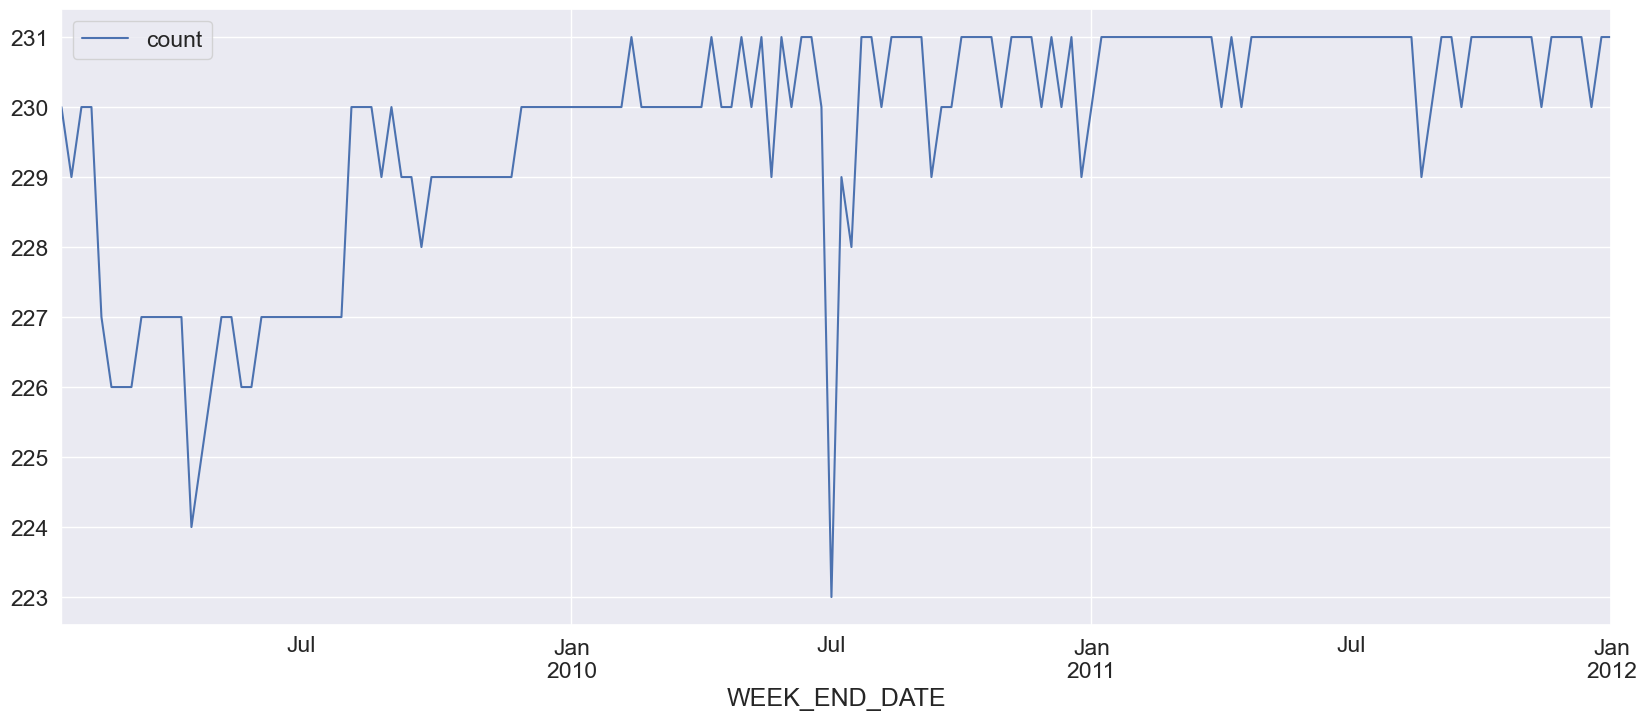

In [189]:
# number of transactions for Kellogg cereal
plt.rcParams["figure.figsize"] = [20,8]
sorted_date.plot()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\159100065.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot_units = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="UNITS", ci = None)


Text(0.5, 0, 'Date')

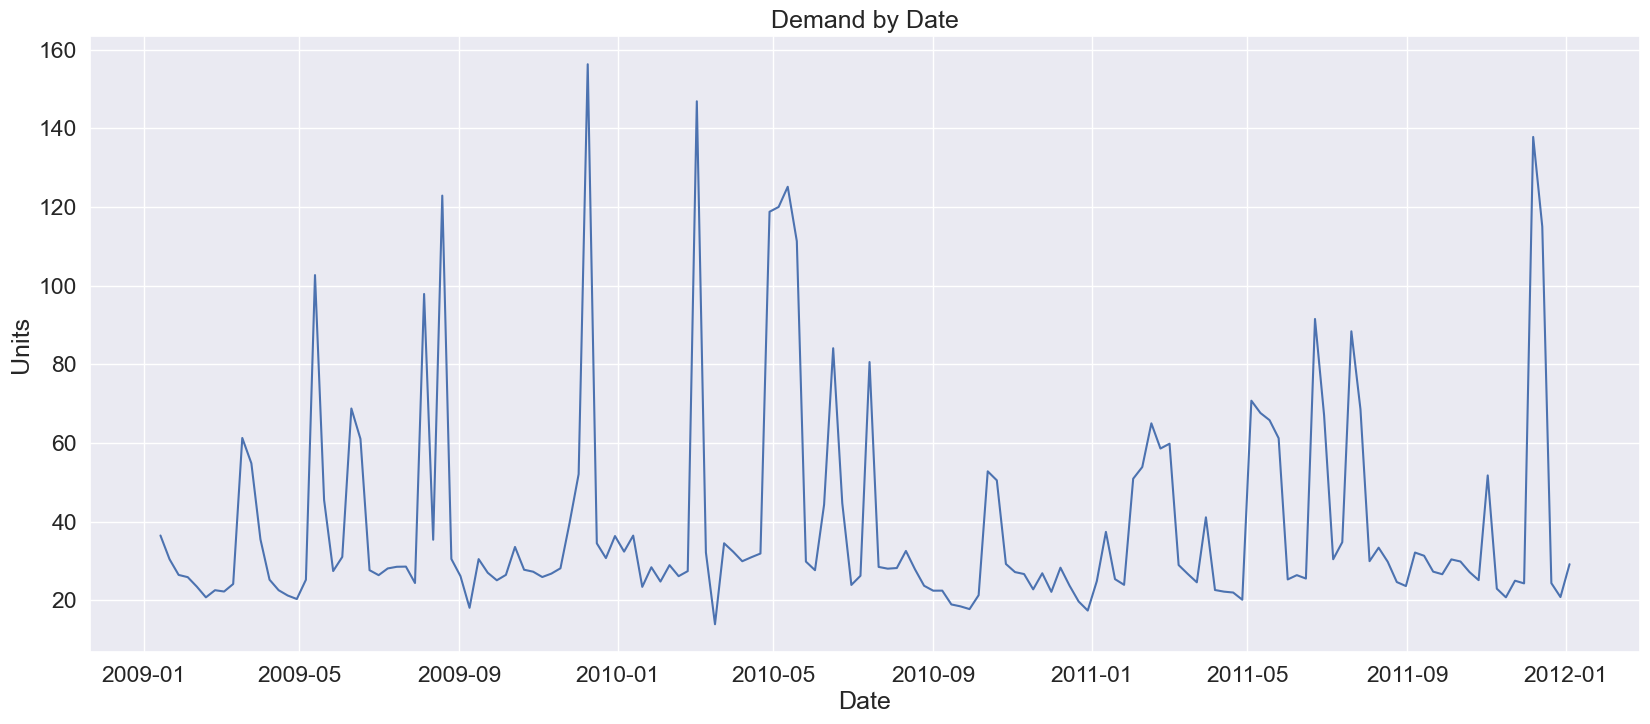

In [191]:
plt.rcParams["figure.figsize"] = [20,8]
plot_units = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="UNITS", ci = None)
plt.title("Demand by Date")
plt.ylabel("Units")
plt.xlabel("Date")

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\1910747175.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot_price = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="PRICE", ci = None, color = 'orange')


Text(0.5, 0, 'Date')

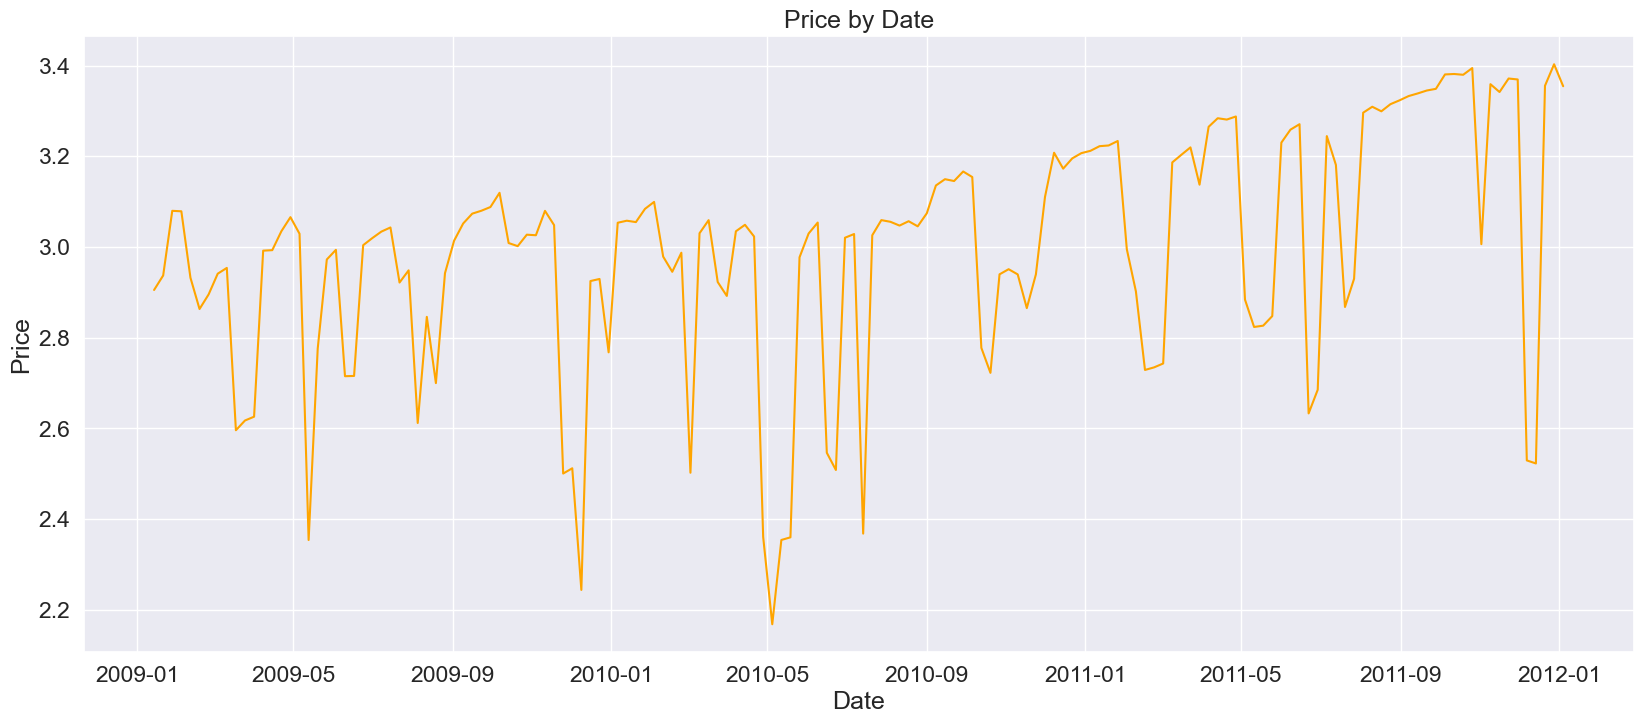

In [193]:
plt.rcParams["figure.figsize"] = [20,8]
plot_price = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="PRICE", ci = None, color = 'orange')
plt.title("Price by Date")
plt.ylabel("Price")
plt.xlabel("Date")

### Price vs Base Price

Text(0.5, 1.0, 'Base Price')

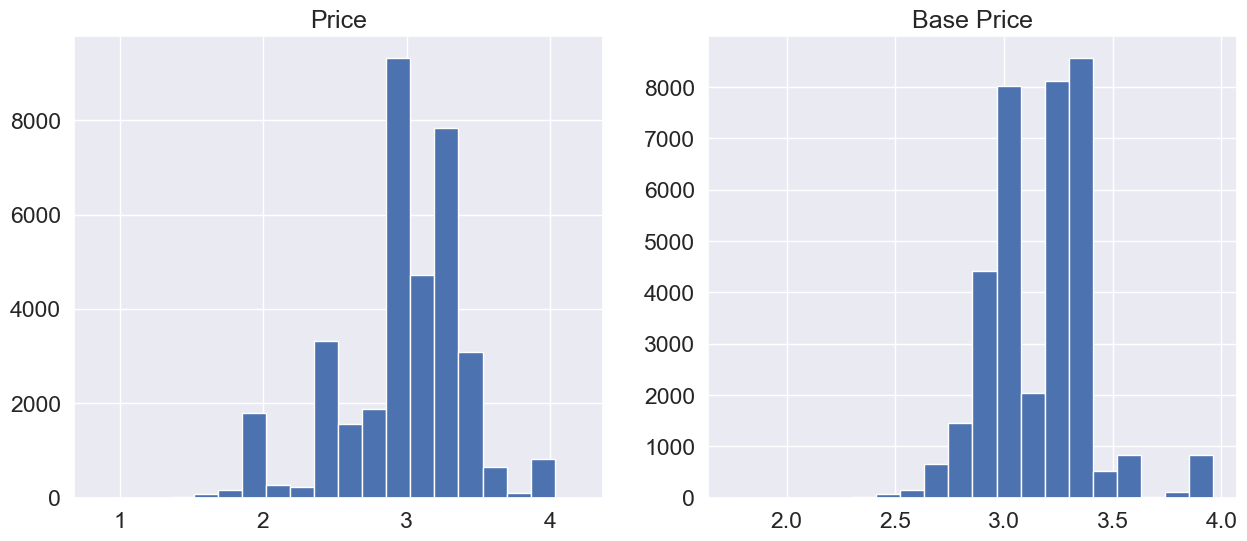

In [196]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.set(font_scale=1.5)
cereal_Kellogg.PRICE.hist(bins=20,ax=ax1) 
ax1.set_title('Price')
cereal_Kellogg.BASE_PRICE.hist(bins=20, ax=ax2) 
ax2.set_title('Base Price')

In [198]:
# 56.04% correlated
cereal_Kellogg[['PRICE','BASE_PRICE']].corr()

,PRICE,BASE_PRICE
PRICE,1.00000,0.56038
BASE_PRICE,0.56038,1.00000


In [200]:
cereal_Kellogg[['PRICE','UNITS']].corr()

,PRICE,UNITS
PRICE,1.000000,-0.555772
UNITS,-0.555772,1.000000


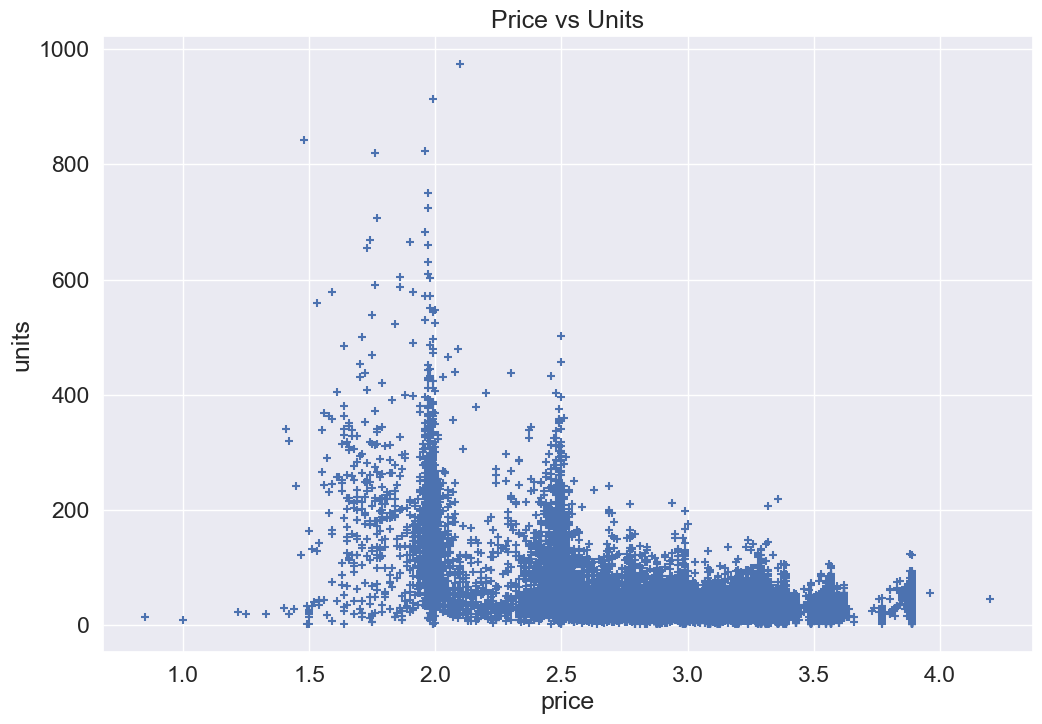

In [202]:
# plt.subplots(3,3)

fig=plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)
plt.scatter(cereal_Kellogg.PRICE, cereal_Kellogg.UNITS,marker='+')
plt.xlabel('price')
plt.ylabel('units')
plt.title('Price vs Units')
plt.show()

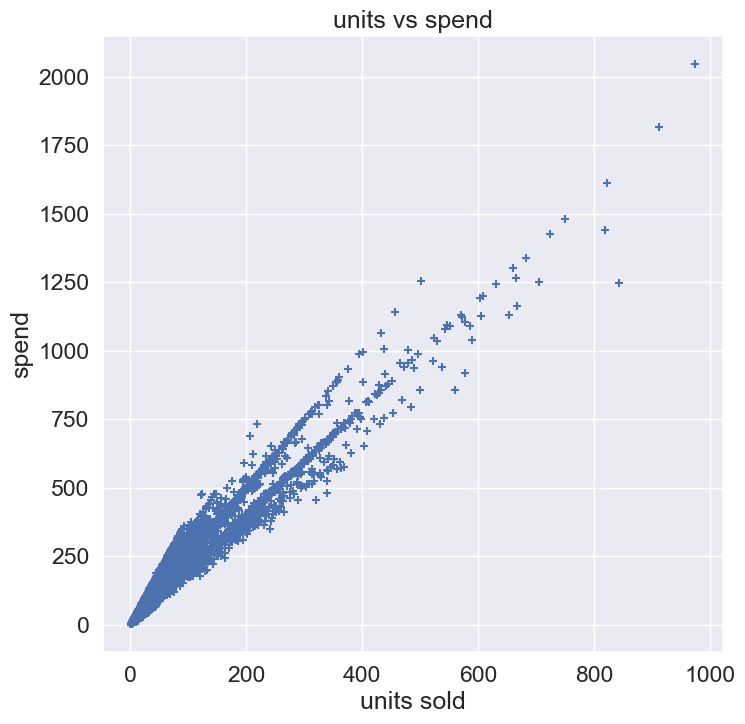

In [204]:
# plt.subplots(3,3)

fig=plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.scatter(cereal_Kellogg.UNITS, cereal_Kellogg.SPEND,marker='+')
plt.xlabel('units sold')
plt.ylabel('spend')
plt.title('units vs spend')
plt.show()

---

### Regression_Predict Price

In [208]:
cereal_Kellogg.groupby("SUB_CATEGORY")[["BASE_PRICE", "PRICE"]].mean()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\3392063075.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg.groupby("SUB_CATEGORY")[["BASE_PRICE", "PRICE"]].mean()


,BASE_PRICE,PRICE
SUB_CATEGORY,,
ALL FAMILY CEREAL,3.273618,3.164362
KIDS CEREAL,3.094547,2.908529


In [210]:
cereal_Kellogg.groupby("UPC")[["BASE_PRICE", "PRICE"]].mean()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\1286568714.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg.groupby("UPC")[["BASE_PRICE", "PRICE"]].mean()


,BASE_PRICE,PRICE
UPC,,
3800031829,3.273618,3.164362
3800031838,3.044505,2.886601
3800039118,3.144723,2.930515


In [212]:
cereal_Kellogg.groupby("UPC")["SPEND"].sum()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\569243590.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg.groupby("UPC")["SPEND"].sum()


UPC
3800031829    1216282.24
3800031838    1483799.52
3800039118    1151163.13
Name: SPEND, dtype: float64

#### UPC = 3800031829 (Family Cereal)

In [215]:
#data['Date'] = pd.to_datetime(data['Date'])

In [217]:
cereal_Kellogg_p1 = cereal_Kellogg[cereal_Kellogg.UPC == 3800031829]
cereal_Kellogg_p1.set_index('WEEK_END_DATE',inplace=True)
cereal_Kellogg_p1 = cereal_Kellogg_p1[cereal_Kellogg_p1.columns[cereal_Kellogg_p1.nunique()!=1]]
cereal_Kellogg_p1.nunique()

STORE_NUM                    77
UNITS                       218
VISITS                      179
HHS                         172
SPEND                      2847
PRICE                       185
BASE_PRICE                  117
FEATURE                       2
DISPLAY                       2
TPR_ONLY                      2
STORE_ID                     77
STORE_NAME                   73
ADDRESS_CITY_NAME            51
ADDRESS_STATE_PROV_CODE       4
MSA_CODE                      9
SEG_VALUE_NAME                3
PARKING_SPACE_QTY            24
SALES_AREA_SIZE_NUM          73
AVG_WEEKLY_BASKETS           77
MONTH                        12
YEAR                          4
UNITS/VISITS                916
VISITS/HHS                  742
dtype: int64

Text(0, 0.5, 'units sold')

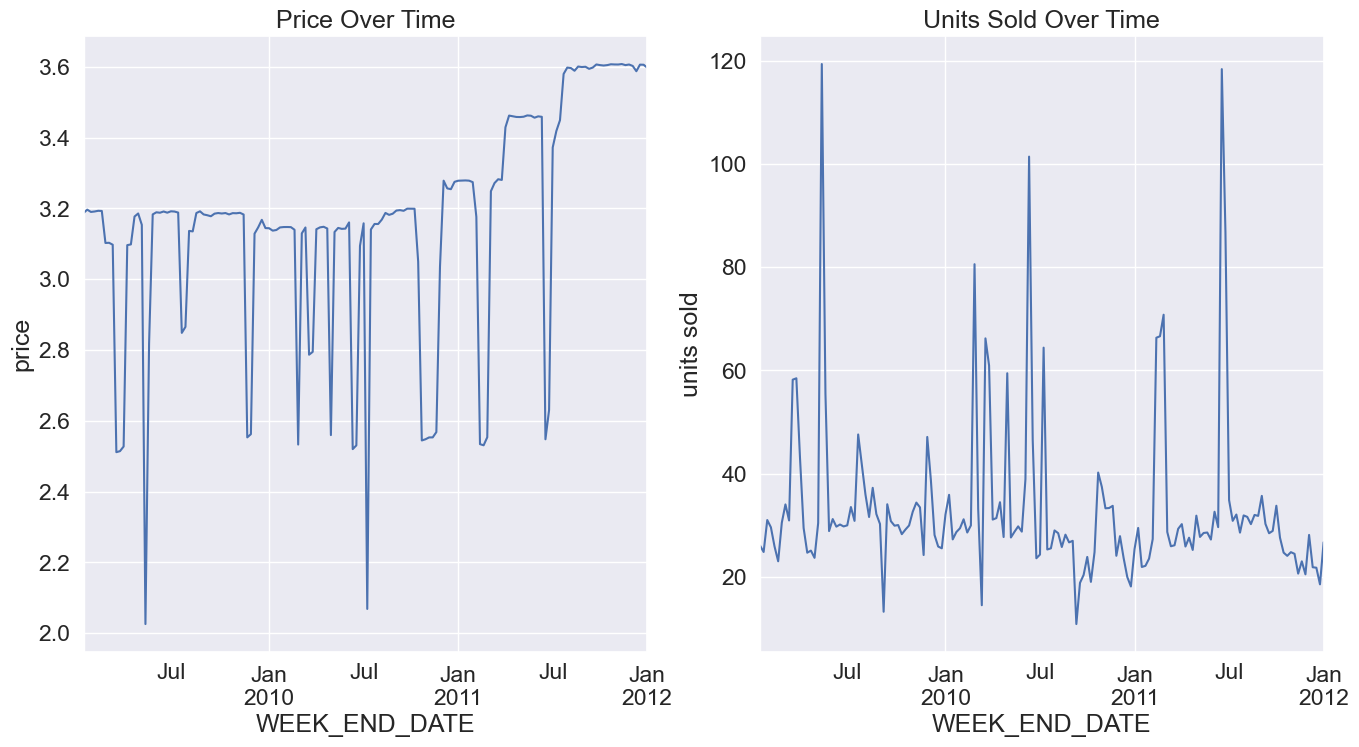

In [219]:
## In both graphs of historical price and units sold we can observe seasonality
## More sales on Sprint to Summer. 
f, ax=plt.subplots(1, 2, figsize=(16,8))
sns.set(font_scale=1.5)
cereal_Kellogg_p1.groupby('WEEK_END_DATE')['PRICE'].mean().plot(ax=ax[0])
ax[0].set_title('Price Over Time')
ax[0].set_ylabel('price')
cereal_Kellogg_p1.groupby('WEEK_END_DATE')['UNITS'].mean().plot(ax=ax[1])
ax[1].set_title('Units Sold Over Time')
ax[1].set_ylabel('units sold')

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\426406029.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg_p1.groupby('MONTH')['PRICE'].mean().plot(ax=ax[0])
C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\426406029.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cereal_Kellogg_p1.groupby('MONTH')['UNITS'].mean().plot(ax=ax[1])


Text(0, 0.5, 'units')

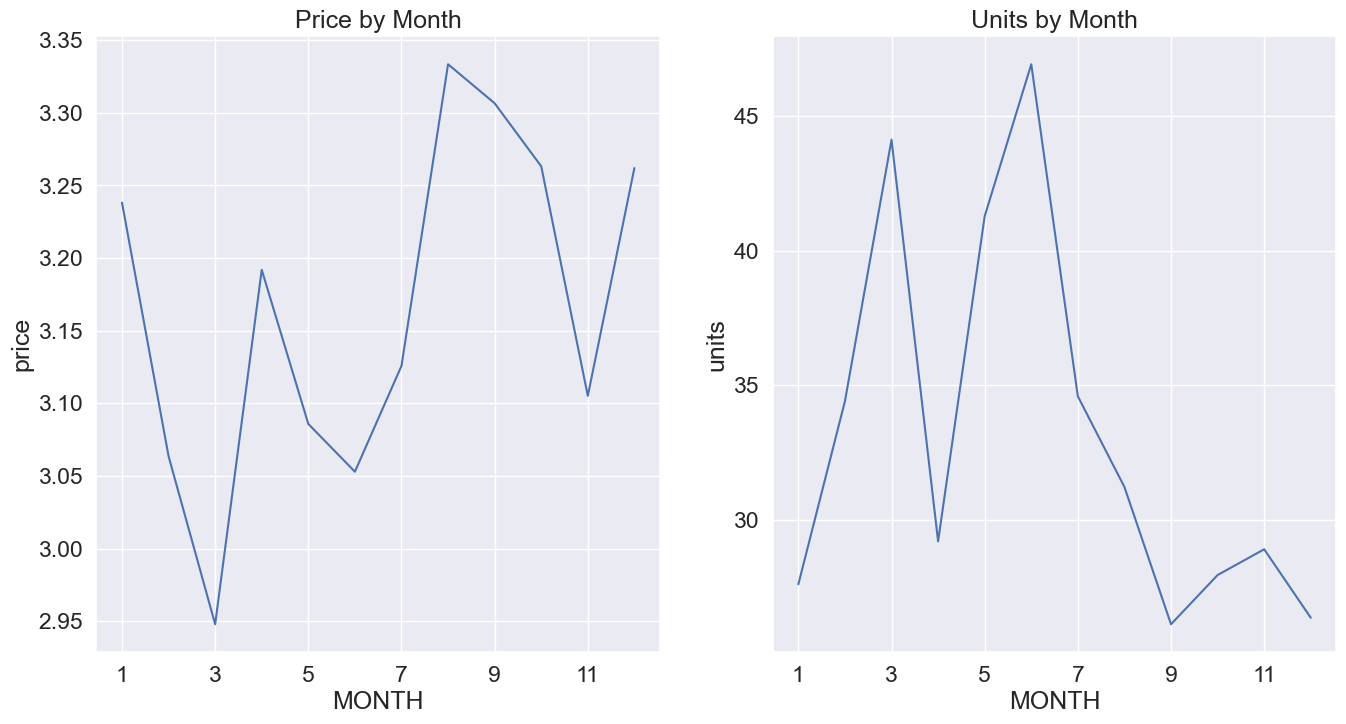

In [220]:
## In both graphs of historical price and units sold we can observe seasonality
## More sales on Sprint to Summer. 
f, ax=plt.subplots(1, 2, figsize=(16,8))
sns.set(font_scale=1.5)
cereal_Kellogg_p1.groupby('MONTH')['PRICE'].mean().plot(ax=ax[0])
ax[0].set_title('Price by Month')
ax[0].set_ylabel('price')
cereal_Kellogg_p1.groupby('MONTH')['UNITS'].mean().plot(ax=ax[1])
ax[1].set_title('Units by Month')
ax[1].set_ylabel('units')

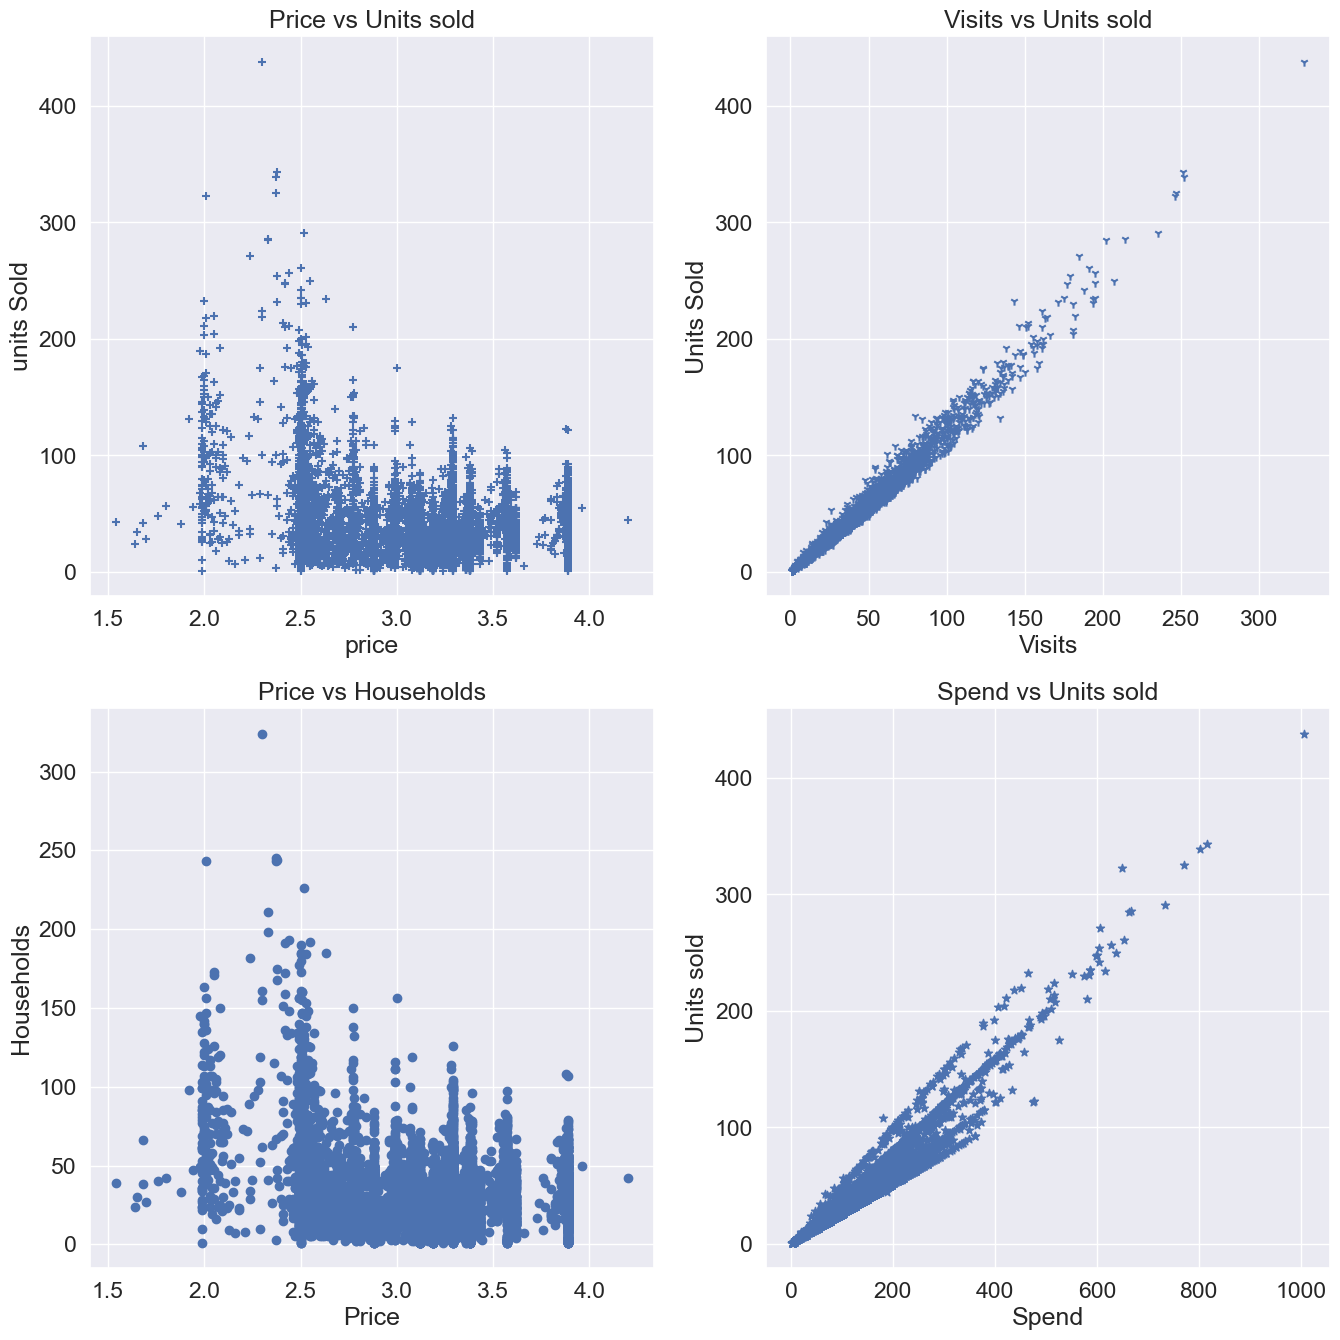

In [223]:
f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
ax[0,0].scatter(cereal_Kellogg_p1.PRICE, cereal_Kellogg_p1.UNITS, marker='+')
ax[0,0].set_xlabel('price')
ax[0,0].set_ylabel('units Sold')
ax[0,0].set_title('Price vs Units sold')

ax[0,1].scatter(cereal_Kellogg_p1.VISITS, cereal_Kellogg_p1.UNITS, marker='1')
ax[0,1].set_xlabel('Visits')
ax[0,1].set_ylabel('Units Sold')
ax[0,1].set_title('Visits vs Units sold')

ax[1,0].scatter(cereal_Kellogg_p1.PRICE, cereal_Kellogg_p1.HHS, marker='o')
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Households')
ax[1,0].set_title('Price vs Households')

ax[1,1].scatter(cereal_Kellogg_p1.SPEND, cereal_Kellogg_p1.UNITS, marker='*')
ax[1,1].set_xlabel('Spend')
ax[1,1].set_ylabel('Units sold')
ax[1,1].set_title('Spend vs Units sold')

plt.show()

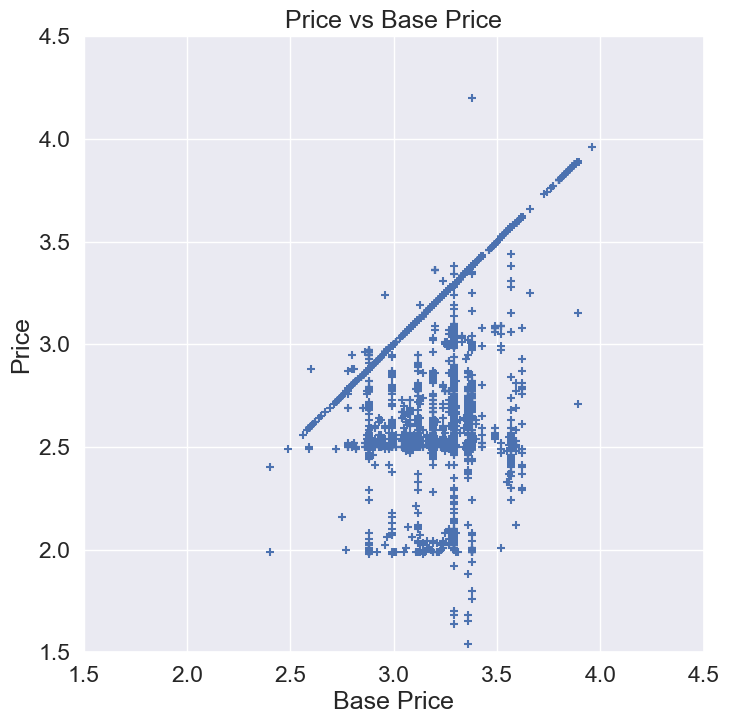

In [224]:
fig = plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.title('Price vs Base Price')
plt.xlabel('Base Price')
plt.ylabel('Price')
plt.xlim(1.5, 4.5)
plt.ylim(1.5, 4.5)
plt.scatter(cereal_Kellogg_p1.BASE_PRICE, cereal_Kellogg_p1.PRICE ,marker='+')

In [227]:
cereal_Kellogg_p1['DISCOUNT'] = cereal_Kellogg_p1.PRICE / cereal_Kellogg_p1.BASE_PRICE

In [229]:
## Fill missing values in PARKING_SPACE_QTY column with median of that column
## there are extreme high and low values so it's not an good idea to take the mean.

#cereal_Kellogg_p1.PARKING_SPACE_QTY.value_counts()
medPSQ = cereal_Kellogg_p1.PARKING_SPACE_QTY.median()
cereal_Kellogg_p1.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)
#cereal_Kellogg_p1.info()

C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\4011714046.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cereal_Kellogg_p1.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)


In [231]:
cereal_Kellogg_p1 = pd.get_dummies(cereal_Kellogg_p1, columns=['ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME' ])

In [233]:
cereal_Kellogg_p1.columns

Index(['STORE_NUM', 'UNITS', 'VISITS', 'HHS', 'SPEND', 'PRICE', 'BASE_PRICE',
       'FEATURE', 'DISPLAY', 'TPR_ONLY', 'STORE_ID', 'STORE_NAME',
       'ADDRESS_CITY_NAME', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM',
       'AVG_WEEKLY_BASKETS', 'MONTH', 'YEAR', 'UNITS/VISITS', 'VISITS/HHS',
       'DISCOUNT', 'ADDRESS_STATE_PROV_CODE_IN', 'ADDRESS_STATE_PROV_CODE_KY',
       'ADDRESS_STATE_PROV_CODE_OH', 'ADDRESS_STATE_PROV_CODE_TX',
       'MSA_CODE_13140', 'MSA_CODE_17140', 'MSA_CODE_17780', 'MSA_CODE_19100',
       'MSA_CODE_19380', 'MSA_CODE_26420', 'MSA_CODE_43300', 'MSA_CODE_44220',
       'MSA_CODE_47540', 'SEG_VALUE_NAME_MAINSTREAM', 'SEG_VALUE_NAME_UPSCALE',
       'SEG_VALUE_NAME_VALUE'],
      dtype='object')

In [235]:
numeric = ["UNITS", "VISITS", "HHS", "SPEND", "PRICE", "BASE_PRICE", "PARKING_SPACE_QTY", "SALES_AREA_SIZE_NUM", "AVG_WEEKLY_BASKETS", "UNITS/VISITS", "VISITS/HHS", "DISCOUNT"]

In [237]:
y = cereal_Kellogg_p1.PRICE
X = cereal_Kellogg_p1.drop(columns=['STORE_NUM', 'STORE_ID', 'PRICE', 'BASE_PRICE', 'SPEND', 'ADDRESS_CITY_NAME', 'STORE_NAME',
                                    'UNITS/VISITS', 'VISITS/HHS', 'MONTH', "YEAR"])
X.columns

Index(['UNITS', 'VISITS', 'HHS', 'FEATURE', 'DISPLAY', 'TPR_ONLY',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS',
       'DISCOUNT', 'ADDRESS_STATE_PROV_CODE_IN', 'ADDRESS_STATE_PROV_CODE_KY',
       'ADDRESS_STATE_PROV_CODE_OH', 'ADDRESS_STATE_PROV_CODE_TX',
       'MSA_CODE_13140', 'MSA_CODE_17140', 'MSA_CODE_17780', 'MSA_CODE_19100',
       'MSA_CODE_19380', 'MSA_CODE_26420', 'MSA_CODE_43300', 'MSA_CODE_44220',
       'MSA_CODE_47540', 'SEG_VALUE_NAME_MAINSTREAM', 'SEG_VALUE_NAME_UPSCALE',
       'SEG_VALUE_NAME_VALUE'],
      dtype='object')

In [239]:
%%time
tscv = TimeSeriesSplit(n_splits=3)
print('Ridge scores')

result = []
for train_index, test_index in tscv.split(X):
    X_train = X.iloc[train_index,:] 
    X_test = X.iloc[test_index,:] 
    y_train = y[train_index]
    y_test = y[test_index]
    reg1 = linear_model.Ridge(alpha=[.5]).fit(X_train,y_train)
    reg1_score = reg1.score(X_test,y_test)
    print(reg1_score)
    result.append(reg1_score)
    #print(reg1.coef_ )
print("-----------------")
print("Mean Score:", round(mean(result),4))

Ridge scores


<timed exec>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


InvalidParameterError: The 'alpha' parameter of Ridge must be a float in the range [0.0, inf) or an instance of 'numpy.ndarray'. Got [0.5] instead.

In [241]:
%%time
tscv = TimeSeriesSplit(n_splits=3)
print('Ridge scores')

result = []
for train_index, test_index in tscv.split(X):
    X_train = X.iloc[train_index, :] 
    X_test = X.iloc[test_index, :] 
    y_train = y[train_index]
    y_test = y[test_index]
    reg1 = linear_model.Ridge(alpha=0.5).fit(X_train, y_train)  # Fixed alpha
    reg1_score = reg1.score(X_test, y_test)
    print(reg1_score)
    result.append(reg1_score)

print("-----------------")
print("Mean Score:", round(mean(result), 4))


Ridge scores
0.6347614323325452
0.7136953063105741
0.6782782315968989
-----------------
Mean Score: 0.6756
CPU times: total: 0 ns
Wall time: 25.8 ms


<timed exec>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed e

In [243]:
reg1.coef_

array([ 1.37243779e-03, -8.42949502e-03,  5.39883620e-03, -1.27642735e-01,
       -3.44076195e-03, -1.73124230e-01,  1.14470263e-05,  1.20583501e-06,
        4.70050045e-07,  2.84741842e+00,  1.26596172e-01,  1.81568485e-02,
       -1.26943137e-02, -1.32058707e-01, -2.08265622e-01,  7.52051510e-02,
        1.04127703e-02,  9.72470588e-02,  4.24791523e-02, -1.33327691e-01,
        1.01874777e-01,  0.00000000e+00,  1.43744041e-02, -4.77230557e-03,
        6.96031922e-03, -2.18801365e-03])

In [245]:
price1 = reg1.predict(X)
sales1 = price1 * X.UNITS
print("Price:",round(price1.mean(),2))
print("Sales:",round(sales1.sum(),2))

Price: 3.16
Sales: 1213773.99


<Axes: xlabel='WEEK_END_DATE'>

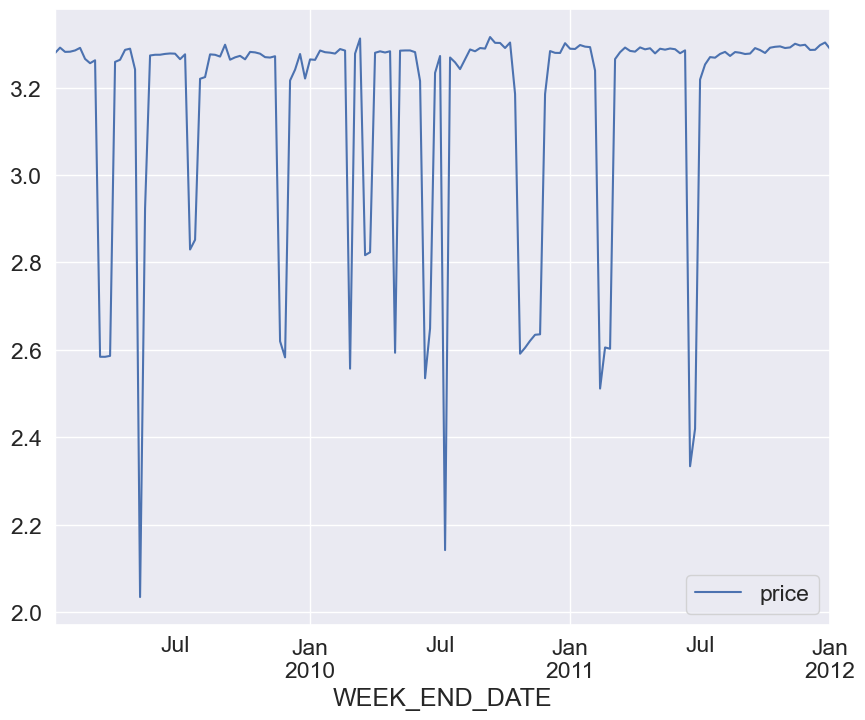

In [247]:
price_df=pd.DataFrame(price1, index=cereal_Kellogg_p1.index)
price_df.columns=['price']

plt.rcParams["figure.figsize"] = [10,8]
price_df = price_df.groupby('WEEK_END_DATE')['price'].mean().reset_index().set_index('WEEK_END_DATE')
price_df.plot()

In [249]:
round(float(price_df.tail().mean()), 2)
print("'Optimal' price for next two weeks for the product with UPC 3800031829 is:", round(float(price_df.tail().mean()), 2))

'Optimal' price for next two weeks for the product with UPC 3800031829 is: 3.29


C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\1037249340.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  round(float(price_df.tail().mean()), 2)
C:\Users\ashis\AppData\Local\Temp\ipykernel_8488\1037249340.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("'Optimal' price for next two weeks for the product with UPC 3800031829 is:", round(float(price_df.tail().mean()), 2))


### Regression_Predict Demand

In [254]:
cereal_Kellogg.corr(method='pearson')

ValueError: could not convert string to float: 'KELL BITE SIZE MINI WHEAT'

In [256]:
# Select only numeric columns
numeric_columns = cereal_Kellogg.select_dtypes(include=['number'])

# Calculate correlation on numeric columns
correlation_matrix = numeric_columns.corr(method='pearson')
print(correlation_matrix)


                        UNITS    VISITS       HHS     SPEND     PRICE  \
UNITS                1.000000  0.992420  0.989704  0.971500 -0.555772   
VISITS               0.992420  1.000000  0.998354  0.969896 -0.555260   
HHS                  0.989704  0.998354  1.000000  0.964874 -0.563047   
SPEND                0.971500  0.969896  0.964874  1.000000 -0.438716   
PRICE               -0.555772 -0.555260 -0.563047 -0.438716  1.000000   
BASE_PRICE          -0.062800 -0.073570 -0.082402 -0.001569  0.560380   
PARKING_SPACE_QTY    0.178354  0.188785  0.183566  0.238104  0.053596   
SALES_AREA_SIZE_NUM  0.199367  0.212419  0.218057  0.265769  0.028477   
AVG_WEEKLY_BASKETS   0.232207  0.251860  0.253557  0.302695 -0.012177   
UNITS/VISITS         0.347780  0.281619  0.269983  0.348923 -0.235770   
VISITS/HHS          -0.018134 -0.026973 -0.064030 -0.001137  0.117850   

                     BASE_PRICE  PARKING_SPACE_QTY  SALES_AREA_SIZE_NUM  \
UNITS                 -0.062800           0.1783

In [258]:
cereal_Kellogg['WEEK_END_DATE'] = pd.to_datetime(cereal_Kellogg['WEEK_END_DATE'])
cereal_Kellogg['MONTH'] = cereal_Kellogg['WEEK_END_DATE'].dt.month
cereal_Kellogg['YEAR'] = cereal_Kellogg['WEEK_END_DATE'].dt.year
cereal_Kellogg['MONTH'] = cereal_Kellogg['MONTH'].astype("category")
cereal_Kellogg['YEAR'] = cereal_Kellogg['YEAR'].astype("category")

In [260]:
cereal_Kellogg_std = rsm.scale_df(cereal_Kellogg)
cereal_Kellogg_std

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,MONTH,YEAR,UNITS/VISITS,VISITS/HHS
Index,,,,,,,,,,,,,,,,,,,,,
1331,2009-01-14,367,3800031829,-0.263394,-0.304464,-0.398953,-0.308174,0.176502,-0.029524,0,...,KY,17140,VALUE,-0.356041,-0.904379,-0.659818,1,2009,1.016916,7.315980
1332,2009-01-21,367,3800031829,-0.232595,-0.280076,-0.361520,-0.262472,0.176502,-0.029524,0,...,KY,17140,VALUE,-0.356041,-0.904379,-0.659818,1,2009,1.192877,3.135538
1333,2009-01-28,367,3800031829,-0.170998,-0.206910,-0.336565,-0.171069,0.176502,-0.029524,0,...,KY,17140,VALUE,-0.356041,-0.904379,-0.659818,1,2009,0.703890,3.716155
1334,2009-02-04,367,3800031829,-0.150466,-0.158133,-0.311610,-0.140601,0.176502,-0.029524,0,...,KY,17140,VALUE,-0.356041,-0.904379,-0.659818,2,2009,0.082025,3.507133
1335,2009-02-11,367,3800031829,-0.170998,-0.206910,-0.299132,-0.171069,0.176502,-0.029524,0,...,KY,17140,VALUE,-0.356041,-0.904379,-0.659818,2,2009,0.703890,1.910965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169275,2011-12-07,29159,3800039118,0.783755,0.890573,0.911194,0.592857,-1.221250,0.475121,1,...,TX,19100,MAINSTREAM,NaN,0.219628,0.095434,12,2011,-0.032395,-0.090111
169276,2011-12-14,29159,3800039118,0.424439,0.427191,0.449523,0.260574,-1.209201,0.475121,1,...,TX,19100,MAINSTREAM,NaN,0.219628,0.095434,12,2011,0.353219,-0.115916
169277,2011-12-21,29159,3800039118,-0.304459,-0.316659,-0.311610,-0.357466,0.465692,0.475121,0,...,TX,19100,MAINSTREAM,NaN,0.219628,0.095434,12,2011,-0.355583,-0.115916


In [262]:
reg = smf.ols(formula = 'UNITS ~ PRICE', data = cereal_Kellogg_std)
reg_model = reg.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  UNITS   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                 1.601e+04
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:53:00   Log-Likelihood:                -19388.
No. Observations:               35832   AIC:                         3.878e+04
Df Residuals:                   35830   BIC:                         3.880e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.814e-17      0.002  -2.19e-14      1.0

In [264]:
reg = smf.ols(formula = 'UNITS ~ PRICE + DISPLAY + FEATURE + TPR_ONLY + SUB_CATEGORY + ADDRESS_STATE_PROV_CODE + AVG_WEEKLY_BASKETS', data = cereal_Kellogg)
reg_model = reg.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  UNITS   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     4125.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:53:01   Log-Likelihood:            -1.7734e+05
No. Observations:               35832   AIC:                         3.547e+05
Df Residuals:                   35822   BIC:                         3.548e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

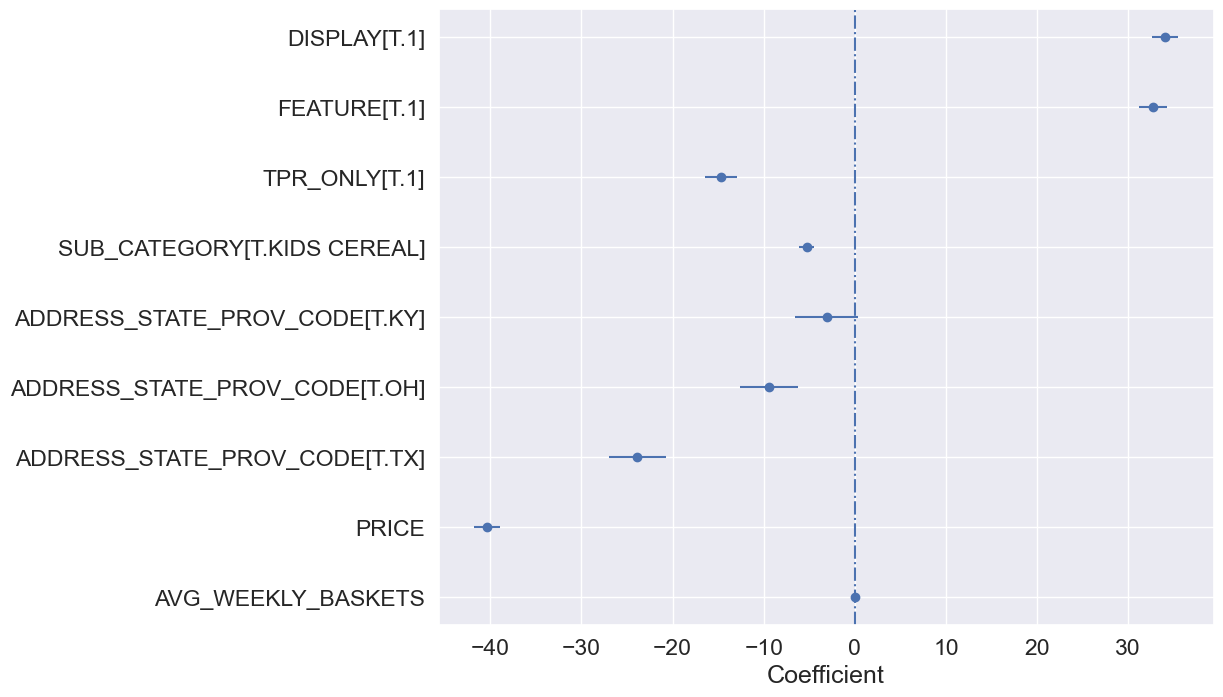

In [267]:
plt.rcParams["figure.figsize"] = [10,8]
fig = rsm.coef_plot(reg_model)

In [269]:
rsm.vif(reg)

,vif,Rsq
PRICE,2.787,0.641
FEATURE,2.125,0.529
DISPLAY,1.746,0.427
TPR_ONLY,1.402,0.287
SUB_CATEGORY,1.152,0.132
ADDRESS_STATE_PROV_CODE,1.096,0.088
AVG_WEEKLY_BASKETS,1.039,0.038


In [271]:
rsm.or_ci(reg_model)

,index,OR,OR%,2.5%,97.5%,p.values,
1,DISPLAY[T.1],6.038718e+14,6.038717662418695e+16%,1.396132e+14,2.611938e+15,< .001,***
2,FEATURE[T.1],1.658998e+14,1.6589982681870478e+16%,3.640993e+13,7.559133e+14,< .001,***
3,TPR_ONLY[T.1],0.000000e+00,-100.0%,0.000000e+00,0.000000e+00,< .001,***
4,SUB_CATEGORY[T.KIDS CEREAL],5.000000e-03,-99.5%,2.000000e-03,1.100000e-02,< .001,***
5,ADDRESS_STATE_PROV_CODE[T.KY],4.600000e-02,-95.4%,1.000000e-03,1.461000e+00,0.081,.
6,ADDRESS_STATE_PROV_CODE[T.OH],0.000000e+00,-100.0%,0.000000e+00,2.000000e-03,< .001,***
7,ADDRESS_STATE_PROV_CODE[T.TX],0.000000e+00,-100.0%,0.000000e+00,0.000000e+00,< .001,***
8,PRICE,0.000000e+00,-100.0%,0.000000e+00,0.000000e+00,< .001,***
9,AVG_WEEKLY_BASKETS,1.001000e+00,0.1%,1.001000e+00,1.001000e+00,< .001,***


In [273]:
cereal_Kellogg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35832 entries, 1331 to 169279
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WEEK_END_DATE            35832 non-null  datetime64[ns]
 1   STORE_NUM                35832 non-null  category      
 2   UPC                      35832 non-null  category      
 3   UNITS                    35832 non-null  int64         
 4   VISITS                   35832 non-null  int64         
 5   HHS                      35832 non-null  int64         
 6   SPEND                    35832 non-null  float64       
 7   PRICE                    35832 non-null  float64       
 8   BASE_PRICE               35830 non-null  float64       
 9   FEATURE                  35832 non-null  category      
 10  DISPLAY                  35832 non-null  category      
 11  TPR_ONLY                 35832 non-null  category      
 12  DESCRIPTION              35832 no